In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import Trainer, TrainingArguments, BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling
from datasets import Dataset as HFDataset # Renamed to avoid conflict with surprise.Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import random #


In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import random

# --- Utility Function for reproducibility ---
def set_seed(seed=42):
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# --- Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device for models: {device}")

# 1. Data Aggregation and Preprocessing
print("\n--- Phase 1: Data Loading, Preprocessing, and Splitting ---")
df = pd.read_csv('travel_recommendations_10k.csv')

# Handle missing values
numerical_columns = ['age', 'travel_rating']
categorical_columns = ['gender', 'hobby', 'budget', 'travel_style', 'activities', 'climate']

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])

# Add destination_key for unique ID (useful for SVD and tracking)
df['destination_key'] = df['destination_city'] + '__' + df['destination_country']

# Create combined textual features for embeddings and LLM prompts
df['destination_description'] = (
    df['destination_city'] + " " + df['destination_country'] + " " +
    df['activities'].fillna('') + " " + df['climate'].fillna('')
)
df['user_profile_text'] = (
    df['age'].astype(str) + " " + df['gender'] + " " + df['hobby'] + " " +
    df['budget'] + " " + df['travel_style']
)
df['travel_rating'] = df['travel_rating'].astype(int) # Ensure rating is int for prompts

print(f"Original dataset loaded and preprocessed with {len(df)} samples.")

# Split the DataFrame into training and testing sets (80/20 ratio)
print("Splitting dataset into 80/20 train-test sets...")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")
print("Data splitting complete. Proceeding with model training.")

Using device for models: cuda

--- Phase 1: Data Loading, Preprocessing, and Splitting ---
Original dataset loaded and preprocessed with 10000 samples.
Splitting dataset into 80/20 train-test sets...
Training dataset shape: (8000, 14)
Testing dataset shape: (2000, 14)
Data splitting complete. Proceeding with model training.


In [5]:
import faiss
from sentence_transformers import SentenceTransformer
from annoy import AnnoyIndex

# --- Ensure 'train_df' and 'device' are available from the previous cell ---

print("\n--- MiniLM Training: Generating Embeddings and Building Indices ---")

# 3. Generate Destination Embeddings (via MiniLM)
# This model acts as your "Fine-Tuned LLM" for embedding generation in your flowchart.
# Sentence-Transformers are already highly optimized for this.
print("Loading SentenceTransformer (MiniLM) for embeddings...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_model.to(device) # Move embedding model to GPU if available
print("SentenceTransformer (MiniLM) loaded.")

def generate_embedding_for_destination(text_series):
    """Generates sentence embeddings for a list of texts."""
    # Use the 'destination_description' created in the preprocessing step
    return embedding_model.encode(text_series.tolist(), convert_to_numpy=True)

print("Generating destination embeddings for training data...")
# Generate embeddings only for the training data
train_embedding_matrix = generate_embedding_for_destination(train_df['destination_description'])
train_embedding_matrix = train_embedding_matrix.astype('float32') # FAISS requires float32
print(f"Generated {len(train_embedding_matrix)} training destination embeddings with dimension {train_embedding_matrix.shape[1]}.")

# 4. Build Faiss Index for Deep Embeddings
print("\n--- Building FAISS Index for Deep Embeddings (from MiniLM) ---")
dimension = train_embedding_matrix.shape[1]
faiss_index = faiss.IndexFlatL2(dimension) # Using L2 distance for similarity search
faiss_index.add(train_embedding_matrix)
faiss.write_index(faiss_index, 'faiss_index_minilm.idx') # Save with a specific name
print(f"FAISS index built and saved to 'faiss_index_minilm.idx' with {faiss_index.ntotal} vectors.")

# 5. Build Annoy Index for Coarse Filtering
print("\n--- Building Annoy Index for Coarse Filtering (from MiniLM) ---")
annoy_index = AnnoyIndex(dimension, 'angular') # Using angular distance as common for embeddings
for i in range(len(train_embedding_matrix)):
    annoy_index.add_item(i, train_embedding_matrix[i])
annoy_index.build(10) # 10 trees for indexing, balance between build time and search accuracy
annoy_index.save('annoy_index_minilm.ann') # Save with a specific name
print("Annoy index built and saved to 'annoy_index_minilm.ann'.")

print("\nMiniLM related training components (embeddings, FAISS, Annoy) are ready.")


--- MiniLM Training: Generating Embeddings and Building Indices ---
Loading SentenceTransformer (MiniLM) for embeddings...
SentenceTransformer (MiniLM) loaded.
Generating destination embeddings for training data...
Generated 8000 training destination embeddings with dimension 384.

--- Building FAISS Index for Deep Embeddings (from MiniLM) ---
FAISS index built and saved to 'faiss_index_minilm.idx' with 8000 vectors.

--- Building Annoy Index for Coarse Filtering (from MiniLM) ---
Annoy index built and saved to 'annoy_index_minilm.ann'.

MiniLM related training components (embeddings, FAISS, Annoy) are ready.


In [12]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader

# --- MiniLM Fine-Tuning ---
print("\n--- Initiating Fine-Tuning for MiniLM Model ---")

# 1. Prepare the Data for Similarity Training
# We need to create pairs of sentences: (user_profile, destination_description)
# and a similarity score (the travel rating, normalized to be between 0 and 1).
train_examples = []
for _, row in train_df.iterrows():
    user_profile = row['user_profile_text']
    destination_desc = row['destination_description']
    # Normalize the 1-5 rating to a 0.0-1.0 similarity score
    score = (row['travel_rating'] - 1) / 4.0 
    train_examples.append(InputExample(texts=[user_profile, destination_desc], label=score))

# Create a DataLoader for the training set
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

# 2. Prepare the Evaluation Data
eval_examples = []
for _, row in test_df.iterrows():
    user_profile = row['user_profile_text']
    destination_desc = row['destination_description']
    score = (row['travel_rating'] - 1) / 4.0
    eval_examples.append(InputExample(texts=[user_profile, destination_desc], label=score))

# 3. Load the Pre-Trained Model
model_name_minilm = 'all-MiniLM-L6-v2'
model_minilm = SentenceTransformer(model_name_minilm)
model_minilm.to(device)
print(f"Loaded '{model_name_minilm}' for fine-tuning.")

# 4. Define the Loss Function
# CosineSimilarityLoss is ideal for regression tasks where we want the cosine similarity
# between two sentence embeddings to approximate a given score.
train_loss = losses.CosineSimilarityLoss(model=model_minilm)

# 5. Define the Evaluator
# The evaluator will run on the test set after each epoch to measure performance.
# It computes the Spearman rank correlation between the model's computed similarities and the true scores.
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, name='sts-test')
print("Created evaluator for the test set.")

# 6. Fine-Tune the Model
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) # 10% of training steps for warmup
output_path_minilm = "./fine_tuned_minilm_travel"

print(f"Starting fine-tuning. Model will be saved to '{output_path_minilm}'.")

model_minilm.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=500,
          warmup_steps=warmup_steps,
          output_path=output_path_minilm)

print("\n--- MiniLM Fine-Tuning Complete ---")


--- Initiating Fine-Tuning for MiniLM Model ---
Loaded 'all-MiniLM-L6-v2' for fine-tuning.
Created evaluator for the test set.
Starting fine-tuning. Model will be saved to './fine_tuned_minilm_travel'.


Step,Training Loss,Validation Loss,Sts-test Pearson Cosine,Sts-test Spearman Cosine
500,0.027900,No log,0.035860,0.043689



--- MiniLM Fine-Tuning Complete ---


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset # Alias to avoid conflict with surprise.Dataset

# --- Ensure 'train_df', 'test_df' and 'device' are available from the previous cells ---
import torch # Ensure torch is imported for torch.tensor usage

print("\n--- BERT Training: Combined User-Destination Feature Learning ---")

# Define model name for BERT
bert_model_name = 'bert-base-uncased'

# Load BERT Tokenizer
print(f"Loading BERT tokenizer: {bert_model_name}...")
tokenizer_bert = BertTokenizer.from_pretrained(bert_model_name)
print("BERT tokenizer loaded.")

# Prepare dataset for BERT fine-tuning using a prompt-like structure
def create_bert_prompt(row):
    return (
        f"User is {int(row['age'])}, {row['gender']}, enjoys {row['hobby']}, "
        f"budget is {row['budget']}, travel style is {row['travel_style']}. "
        f"The destination is {row['destination_city']}, {row['destination_country']} offering {row['activities']} "
        f"in a {row['climate']} climate."
    )

print("Creating prompt-based dataset for BERT fine-tuning...")
train_texts_bert = [create_bert_prompt(row) for _, row in train_df.iterrows()]
train_labels_bert = train_df['travel_rating'].values.astype(float)

test_texts_bert = [create_bert_prompt(row) for _, row in test_df.iterrows()]
test_labels_bert = test_df['travel_rating'].values.astype(float)

print("Tokenizing datasets for BERT...")
train_encodings_bert = tokenizer_bert(train_texts_bert, truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings_bert = tokenizer_bert(test_texts_bert, truncation=True, padding=True, max_length=512, return_tensors='pt')
print("BERT dataset tokenization complete.")

# Custom Dataset class for BERT (for regression, so labels are floats)
class BertTravelDataset(torch.utils.data.Dataset): # Inherit from torch.utils.data.Dataset directly
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_dataset_bert = BertTravelDataset(train_encodings_bert, train_labels_bert)
test_dataset_bert = BertTravelDataset(test_encodings_bert, test_labels_bert)

# Load BERT model for sequence classification (regression)
print(f"Loading BERT model for regression: {bert_model_name}...")
model_bert = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=1)
model_bert.to(device)
print("BERT model loaded.")

# Training arguments for BERT fine-tuning
training_args_bert = TrainingArguments(
    output_dir='./fine_tuned_bert_travel',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=torch.cuda.is_available(),
    report_to="none",
    # ADDED: This is the crucial line to prevent the AttributeError
    remove_unused_columns=False,
)

# Trainer for BERT fine-tuning
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    tokenizer=tokenizer_bert,
)

print("Starting BERT fine-tuning...")
trainer_bert.train()
print("BERT fine-tuning complete.")

# Save the fine-tuned BERT model and tokenizer
model_bert.save_pretrained("./fine_tuned_bert_travel")
tokenizer_bert.save_pretrained("./fine_tuned_bert_travel")
print("Fine-tuned BERT model and tokenizer saved to './fine_tuned_bert_travel'.")


--- BERT Training: Combined User-Destination Feature Learning ---
Loading BERT tokenizer: bert-base-uncased...
BERT tokenizer loaded.
Creating prompt-based dataset for BERT fine-tuning...
Tokenizing datasets for BERT...
BERT dataset tokenization complete.
Loading BERT model for regression: bert-base-uncased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded.
Starting BERT fine-tuning...


C:\Users\Ausaf raza\AppData\Local\Temp\ipykernel_6460\687497252.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


Epoch,Training Loss,Validation Loss


: 

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, BitsAndBytesConfig, DataCollatorForLanguageModeling
from datasets import Dataset as HFDataset # Alias to avoid conflict if you also use other 'Dataset' classes
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch # Ensure torch is imported

# --- Ensure 'train_df' and 'device' are available from previous cells ---
# If running this cell in isolation, you might need to re-initialize 'device' and load 'train_df'.
try:
    train_df # Check if train_df exists
    device # Check if device exists
except NameError:
    print("WARNING: 'train_df' or 'device' not found. Ensure previous data loading/splitting cells are run.")
    # Fallback/re-initialization for demonstration if run separately (remove for actual sequential notebook use)
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    # Minimal reload for df properties used in prompts
    df = pd.read_csv('travel_recommendations_10k.csv')
    numerical_columns = ['age', 'travel_rating']
    categorical_columns = ['gender', 'hobby', 'budget', 'travel_style', 'activities', 'climate']
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])
    df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])
    df['destination_key'] = df['destination_city'] + '__' + df['destination_country']
    df['destination_description'] = (
        df['destination_city'] + " " + df['destination_country'] + " " +
        df['activities'].fillna('') + " " + df['climate'].fillna('')
    )
    df['user_profile_text'] = (
        df['age'].astype(str) + " " + df['gender'] + " " + df['hobby'] + " " +
        df['budget'] + " " + df['travel_style']
    )
    df['travel_rating'] = df['travel_rating'].astype(int)
    train_df, _ = train_test_split(df, test_size=0.2, random_state=42) # Only need train_df for this cell
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"DEBUG: Re-initialized df and device for standalone cell execution. Device: {device}")


print("\n--- DeepSeek Training: Generative Fine-tuning with Prompts ---")

# Define model name
model_name_llm = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

# Load tokenizer for LLM
print(f"Loading LLM tokenizer: {model_name_llm}...")
tokenizer_llm = AutoTokenizer.from_pretrained(model_name_llm, trust_remote_code=True)
if tokenizer_llm.pad_token is None:
    tokenizer_llm.pad_token = tokenizer_llm.eos_token # Essential for batch processing
print("LLM tokenizer loaded.")

# Quantization config for memory efficiency (crucial for 4GB VRAM)
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True # Enables offloading to CPU RAM if VRAM is insufficient
)

# Load LLM model with quantization and explicit device mapping
print("Loading LLM model with quantization and explicit device mapping...")
  


# Enable gradient checkpointing & prepare for QLoRA training
# Gradient checkpointing reduces VRAM usage by recomputing activations, but slows down training
model_llm.gradient_checkpointing_enable()
model_llm = prepare_model_for_kbit_training(model_llm)

# Apply LoRA configuration (Parameter Efficient Fine-Tuning)
print("Applying LoRA to LLM...")
lora_config = LoraConfig(
    r=8, # Rank of the update matrices. Lower 'r' means fewer trainable parameters.
    lora_alpha=32, # Scaling factor for LoRA updates.
    lora_dropout=0.1, # Dropout probability for LoRA layers.
    bias="none", # Don't apply LoRA to bias terms.
    task_type="CAUSAL_LM" # Specify the task type for the model.
)
model_llm = get_peft_model(model_llm, lora_config)
print("LoRA applied. Trainable parameters:")
model_llm.print_trainable_parameters() # This will show how few parameters are actually being trained

# --- Prompt Engineering for Fine-Tuning ---
# This function creates a structured prompt string for each row of your training dataset.
# The LLM will learn to predict the 'Answer:' based on the 'Question:' and 'Context:'.
def create_fine_tuning_prompt_deepseek(row):
    # This structure trains the model to associate a user's profile with a destination's rating.
    # It explicitly defines the context and the desired output format.
    prompt = (
        f"User Profile: Age {int(row['age'])}, {row['gender']}, enjoys {row['hobby']}, "
        f"budget is {row['budget']}, travel style is {row['travel_style']}.\n"
        f"Destination Details: City {row['destination_city']}, Country {row['destination_country']}, "
        f"activities include {row['activities']}, climate is {row['climate']}.\n"
        f"Question: What is the travel rating for this destination by this user? Answer: {int(row['travel_rating'])}"
    )
    return {"text": prompt}

print("Creating prompt-based dataset for DeepSeek fine-tuning...")
# Use only the training data (train_df) for fine-tuning the LLM
prompts_llm_data = [create_fine_tuning_prompt_deepseek(row) for index, row in train_df.iterrows()]
dataset_llm = HFDataset.from_list(prompts_llm_data)
print(f"Created {len(dataset_llm)} prompts.")
print(f"Example prompt for DeepSeek:\n{dataset_llm[0]['text']}") # Display an example prompt

def tokenize_fn_llm(examples):
    # This will generate input_ids and attention_mask.
    # DataCollatorForLanguageModeling will create 'labels' internally for causal LM.
    return tokenizer_llm(examples["text"], truncation=True, padding="max_length", max_length=512)

print("Tokenizing dataset for DeepSeek fine-tuning...")
tokenized_dataset_llm = dataset_llm.map(tokenize_fn_llm, batched=True)
print("DeepSeek dataset tokenization complete.")

# Training arguments for LLM fine-tuning
training_args_llm = TrainingArguments(
    output_dir="./fine_tuned_deepseek_travel_prompts", # Output directory for saved model checkpoints
    per_device_train_batch_size=1, # Keep 1 for memory, use gradient_accumulation for effective batch size
    gradient_accumulation_steps=4, # Accumulate gradients over 4 batches, effective batch size = 1 * 4 = 4
    num_train_epochs=3, # Number of full passes over the training data
    logging_steps=100, # Log training progress every 100 steps
    save_steps=500, # Save model checkpoint every 500 steps
    save_total_limit=2, # Keep only the 2 most recent checkpoints
    fp16=torch.cuda.is_available(), # Use mixed precision (FP16) if GPU is available (saves VRAM)
    report_to="none", # Disable reporting to external services like Weights & Biases
    eval_strategy="no",
    # remove_unused_columns=False, # Often helpful with custom datasets, though DataCollator usually handles this.
                               # Uncomment if you face similar AttributeError as with BERT.
)

# Initialize DataCollator for Language Modeling
# mlm=False for Causal Language Modeling (decoder-only LLMs)
data_collator_llm = DataCollatorForLanguageModeling(tokenizer=tokenizer_llm, mlm=False)

# Trainer for LLM fine-tuning
trainer_llm = Trainer(
    model=model_llm,
    args=training_args_llm,
    train_dataset=tokenized_dataset_llm,
    eval_dataset=tokenized_dataset_eva,
    tokenizer=tokenizer_llm, # Provide tokenizer to Trainer for internal use (e.g., data collator)
    data_collator=data_collator_llm, # Pass the data collator to handle input formatting
)

print("Starting DeepSeek fine-tuning...")
trainer_llm.train()
print("DeepSeek fine-tuning complete.")

# Save the final fine-tuned LLM and its tokenizer
model_llm.save_pretrained("./fine_tuned_deepseek_travel_prompts")
tokenizer_llm.save_pretrained("./fine_tuned_deepseek_travel_prompts")
print("Fine-tuned DeepSeek model and tokenizer saved to './fine_tuned_deepseek_travel_prompts'.")

DEBUG: Re-initialized df and device for standalone cell execution. Device: cuda

--- DeepSeek Training: Generative Fine-tuning with Prompts ---
Loading LLM tokenizer: deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...
LLM tokenizer loaded.
Loading LLM model with quantization and explicit device mapping...


NameError: name 'model_llm' is not defined

In [1]:
import pandas as pd
import numpy as np
import torch
import time # Import for time.sleep
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from transformers import (
    BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, DataCollatorForLanguageModeling
)
from transformers.trainer_utils import EvaluationStrategy, SaveStrategy
from transformers.trainer_utils import IntervalStrategy as LoggingStrategy 

from safetensors import SafetensorError

from datasets import Dataset as HFDataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from surprise import Reader, Dataset, SVD, dump 
import random
import os

# --- Utility Functions (from your project) ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class BertTravelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

def create_bert_prompt(row):
    return (
        f"User is {int(row['age'])}, {row['gender']}, enjoys {row['hobby']}, "
        f"budget is {row['budget']}, travel style is {row['travel_style']}. "
        f"The destination is {row['destination_city']}, {row['destination_country']} offering {row['activities']} "
        f"in a {row['climate']} climate."
    )

def create_fine_tuning_prompt_deepseek(row):
    prompt = (
        f"User Profile: Age {int(row['age'])}, {row['gender']}, enjoys {row['hobby']}, "
        f"budget is {row['budget']}, travel style is {row['travel_style']}.\n"
        f"Destination Details: City {row['destination_city']}, Country {row['destination_country']}, "
        f"activities include {row['activities']}, climate is {row['climate']}.\n"
        f"Question: What is the travel rating for this destination by this user? Answer: {int(row['travel_rating'])}"
    )
    return {"text": prompt}

# --- Function to load and preprocess data for retraining ---
def load_and_preprocess_data_for_retraining(csv_path='travel_recommendations_10k.csv', new_feedback_csv_path=None):
    print("Loading historical data for retraining...")
    df = pd.read_csv(csv_path)

    numerical_columns = ['age', 'travel_rating']
    categorical_columns = ['gender', 'hobby', 'budget', 'travel_style', 'activities', 'climate']
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])
    df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])
    df['destination_key'] = df['destination_city'] + '__' + df['destination_country']
    df['destination_description'] = (
        df['destination_city'] + " " + df['destination_country'] + " " +
        df['activities'].fillna('') + " " + df['climate'].fillna('')
    )
    df['user_profile_text'] = (
        df['age'].astype(str) + " " + df['gender'] + " " + df['hobby'] + " " +
        df['budget'] + " " + df['travel_style']
    )
    df['travel_rating'] = df['travel_rating'].astype(int)

    if new_feedback_csv_path and os.path.exists(new_feedback_csv_path):
        print(f"Loading new feedback from {new_feedback_csv_path}...")
        new_df = pd.read_csv(new_feedback_csv_path)
        new_df[numerical_columns] = imputer_num.transform(new_df[numerical_columns])
        new_df[categorical_columns] = imputer_cat.transform(new_df[categorical_columns])
        new_df['destination_key'] = new_df['destination_city'] + '__' + new_df['destination_country']
        new_df['destination_description'] = (
            new_df['destination_city'] + " " + new_df['destination_country'] + " " +
            new_df['activities'].fillna('') + " " + new_df['climate'].fillna('')
        )
        new_df['user_profile_text'] = (
            new_df['age'].astype(str) + " " + new_df['gender'] + " " + new_df['hobby'] + " " +
            new_df['budget'] + " " + new_df['travel_style']
        )
        new_df['travel_rating'] = new_df['travel_rating'].astype(int)
        df = pd.concat([df, new_df], ignore_index=True)
        print(f"Combined data now has {len(df)} samples.")
    else:
        print("No new feedback CSV provided or found.")

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    return train_df, test_df

# --- Function to fine-tune BERT incrementally ---
def fine_tune_bert_model_incremental(train_df, test_df, device):
    print("\n--- BERT Incremental Fine-tuning ---")
    bert_model_name = 'bert-base-uncased'
    model_path = "./fine_tuned_bert_travel"
    
    tokenizer_bert = BertTokenizer.from_pretrained(model_path if os.path.exists(model_path) else bert_model_name)
    model_bert = BertForSequenceClassification.from_pretrained(model_path if os.path.exists(model_path) else bert_model_name, num_labels=1)
    model_bert.to(device)
    print(f"BERT model loaded onto device: {model_bert.device}")

    train_texts_bert = [create_bert_prompt(row) for _, row in train_df.iterrows()]
    train_labels_bert = train_df['travel_rating'].values.astype(float)
    test_texts_bert = [create_bert_prompt(row) for _, row in test_df.iterrows()]
    test_labels_bert = test_df['travel_rating'].values.astype(float)

    train_encodings_bert = tokenizer_bert(train_texts_bert, truncation=True, padding=True, max_length=512, return_tensors='pt')
    test_encodings_bert = tokenizer_bert(test_texts_bert, truncation=True, padding=True, max_length=512, return_tensors='pt')

    train_dataset_bert = BertTravelDataset(train_encodings_bert, train_labels_bert)
    test_dataset_bert = BertTravelDataset(test_encodings_bert, test_labels_bert)

    training_args_bert = TrainingArguments(
        output_dir=model_path,
        num_train_epochs=1,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        warmup_steps=50,
        weight_decay=0.01,
        logging_dir='./logs_bert_retrain',
        logging_steps=50,
        eval_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        fp16=torch.cuda.is_available(),
        report_to="none",
        remove_unused_columns=False,
    )
    try:
        training_args_bert.evaluation_strategy = EvaluationStrategy.EPOCH
        training_args_bert.save_strategy = SaveStrategy.EPOCH
        training_args_bert.logging_strategy = LoggingStrategy.STEPS
    except AttributeError:
        print("CRITICAL WARNING: Could not set evaluation/save/logging strategies as attributes. Your transformers version is likely severely outdated/corrupted or has a non-standard API.")
        print("Training progress and saving behavior might be unpredictable.")

    trainer_bert = Trainer(
        model=model_bert,
        args=training_args_bert,
        train_dataset=train_dataset_bert,
        eval_dataset=test_dataset_bert, 
        tokenizer=tokenizer_bert,
    )
    trainer_bert.train()
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            model_bert.save_pretrained(model_path)
            tokenizer_bert.save_pretrained(model_path)
            print(f"BERT incremental fine-tuning complete. Model saved to {model_path}")
            break 
        except SafetensorError as e:
            print(f"Attempt {attempt + 1}/{max_retries} to save BERT model failed with SafetensorError: {e}")
            if attempt < max_retries - 1:
                print("Retrying in 5 seconds...")
                time.sleep(5)
            else:
                print("Max retries reached. BERT model save failed.")
    return model_bert, tokenizer_bert

# --- Function to fine-tune DeepSeek incrementally ---
def fine_tune_deepseek_model_incremental(train_df, test_df, device): 
    print("\n--- DeepSeek Incremental Fine-tuning ---")
    model_name_llm_base = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
    model_path = "./fine_tuned_deepseek_travel_prompts"

    tokenizer_llm = AutoTokenizer.from_pretrained(model_path if os.path.exists(model_path) else model_name_llm_base, trust_remote_code=True)
    if tokenizer_llm.pad_token is None:
        tokenizer_llm.pad_token = tokenizer_llm.eos_token

    # Keep BitsAndBytesConfig for 8-bit loading
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True, 
        # llm_int8_enable_fp32_cpu_offload=True # Can comment out if not strictly needed for memory
    )
    
    # Set torch_dtype for the base model loading.
    # If not using fp16/bf16 training (as per changes below), default to float32 or bfloat16 if GPU supports.
    # Given the previous error, using float32 for training clarity might be better.
    base_model = AutoModelForCausalLM.from_pretrained(
        model_name_llm_base,
        quantization_config=bnb_config,
        device_map={'': torch.cuda.current_device()} if torch.cuda.is_available() else "cpu",
        trust_remote_code=True,
        torch_dtype=torch.float32 # Changed to float32 for full precision operations if AMP is off
    )
    print(f"DeepSeek base model loaded onto device: {base_model.device}")

    if os.path.exists(model_path):
        print(f"Loading existing LoRA weights from {model_path} for incremental training.")
        model_llm = PeftModel.from_pretrained(base_model, model_path).to(device)
    else:
        print(f"No existing LoRA weights found. Applying LoRA for the first time.")
        model_llm = prepare_model_for_kbit_training(base_model)
        lora_config = LoraConfig(r=8, lora_alpha=32, lora_dropout=0.1, bias="none", task_type="CAUSAL_LM")
        model_llm = get_peft_model(model_llm, lora_config)
        model_llm.to(device) 
    print(f"DeepSeek LoRA model loaded onto device: {model_llm.device}")

    model_llm.enable_input_require_grads() 
    model_llm.gradient_checkpointing_enable()
    print("LoRA applied. Trainable parameters:")
    model_llm.print_trainable_parameters()

    # --- Diagnostic: Check for None gradients (before Trainer starts) ---
    print("\n--- Diagnostic: Checking for None gradients in trainable parameters ---")
    none_grad_params = []
    for name, param in model_llm.named_parameters():
        # param.grad might be None if no backward pass has occurred yet.
        # This check is more indicative if done inside a training loop, but as an initial check:
        if param.requires_grad and param.grad is None:
            none_grad_params.append(name)
    if none_grad_params:
        print(f"WARNING: The following trainable parameters have None gradients BEFORE training starts: {none_grad_params}")
        print("This is normal at initialization. If this persists during training after a backward pass, it indicates an issue.")
    else:
        print("All trainable parameters have non-None gradients (or don't require gradients) at this stage.")
    print("---------------------------------------------------------------------")


    prompts_llm_data = [create_fine_tuning_prompt_deepseek(row) for index, row in train_df.iterrows()]
    tokenized_train_dataset_llm = HFDataset.from_list(prompts_llm_data).map(lambda examples: tokenizer_llm(examples["text"], truncation=True, padding="max_length", max_length=512), batched=True)

    prompts_llm_eval_data = [create_fine_tuning_prompt_deepseek(row) for index, row in test_df.iterrows()]
    tokenized_eval_dataset_llm = HFDataset.from_list(prompts_llm_eval_data).map(lambda examples: tokenizer_llm(examples["text"], truncation=True, padding="max_length", max_length=512), batched=True)

    training_args_llm = TrainingArguments(
        output_dir=model_path,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs=1,
        logging_steps=50,
        save_steps=500,
        save_total_limit=2,
        report_to="none",
        metric_for_best_model="eval_loss",
        
        # --- CRITICAL CHANGE: Choose a different 8-bit optimizer and remove AMP flags ---
        # "paged_adamw_8bit" is often more stable with 8-bit quantization and PEFT
        optim="paged_adamw_8bit", 
        
        # Explicitly remove fp16=False and bf16=False from here.
        # If we are using optim="paged_adamw_8bit", the scaler should ideally not be involved.
        # If it's still involved and causing issues, then accelerate's internal logic needs investigation.
        # By removing these explicit 'False' settings, we let the optimizer handle its precision.
        
        learning_rate=5e-6, # Keep reduced learning rate for stability
        max_grad_norm=1.0,  # Keep gradient clipping for stability
    )

    try:
        training_args_llm.evaluation_strategy = EvaluationStrategy.EPOCH
        training_args_llm.save_strategy = SaveStrategy.EPOCH
        training_args_llm.logging_strategy = LoggingStrategy.STEPS
    except AttributeError:
        print("CRITICAL WARNING: Could not set evaluation/save/logging strategies as attributes for DeepSeek. Your transformers version is likely severely outdated/corrupted or has a non-standard API.")
        print("Training progress and saving behavior might be unpredictable.")

    data_collator_llm = DataCollatorForLanguageModeling(tokenizer=tokenizer_llm, mlm=False)
    trainer_llm = Trainer(
        model=model_llm,
        args=training_args_llm,
        train_dataset=tokenized_train_dataset_llm,
        eval_dataset=tokenized_eval_dataset_llm,  
        tokenizer=tokenizer_llm,
        data_collator=data_collator_llm,
    )
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("Cleared CUDA cache before DeepSeek training.")

    trainer_llm.train()
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            model_llm.save_pretrained(model_path)
            tokenizer_llm.save_pretrained(model_path)
            print(f"DeepSeek incremental fine-tuning complete. Model saved to {model_path}")
            break
        except SafetensorError as e:
            print(f"Attempt {attempt + 1}/{max_retries} to save DeepSeek model failed with SafetensorError: {e}")
            if attempt < max_retries - 1:
                print("Retrying in 5 seconds...")
                time.sleep(5)
            else:
                print("Max retries reached. DeepSeek model save failed.")
    return model_llm, tokenizer_llm

# --- Main execution block for dynamic retraining ---
if __name__ == "__main__":
    # Ensure this is at the very top for effective debugging.
    torch.autograd.set_detect_anomaly(True)
    print("Enabled torch.autograd.set_detect_anomaly(True) for debugging.")

    set_seed()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n--- Initial GPU Check ---")
    print(f"torch.cuda.is_available(): {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current CUDA device: {torch.cuda.current_device()}")
        print(f"CUDA Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
        print(f"CUDA Device Capability: {torch.cuda.get_device_capability(torch.cuda.current_device())}")
        try:
            total_mem, free_mem = torch.cuda.mem_get_info()
            allocated_mem = torch.cuda.memory_allocated()
            reserved_mem = torch.cuda.memory_reserved()
            print(f"CUDA Device Total Memory: {total_mem / (1024**3):.2f} GB")
            print(f"CUDA Device Free Memory: {free_mem / (1024**3):.2f} GB")
            print(f"CUDA Device Allocated Memory: {allocated_mem / (1024**3):.2f} GB")
            print(f"CUDA Device Reserved Memory: {reserved_mem / (1024**3):.2f} GB")
        except RuntimeError as e:
            print(f"Could not get GPU memory info: {e}. This might happen if no device is selected or memory query fails.")
    else:
        print("CUDA is NOT available in PyTorch. Training will be on CPU, which will be slow.")
        print("Please ensure NVIDIA drivers, CUDA Toolkit, and PyTorch CUDA version are compatible.")
    print("-------------------------")

    # --- Simulate new user feedback by creating a dummy CSV ---
    NEW_FEEDBACK_CSV = 'new_user_feedback.csv' 

    print("\n--- Starting Dynamic LLM & SVD Retraining Process ---")
    print("Please ensure no other processes are locking the model save directories (e.g., fine_tuned_bert_travel, fine_tuned_deepseek_travel_prompts).")
    print("Consider deleting these directories before running if you encounter persistent file errors.")
    
    train_df_updated, test_df_updated = load_and_preprocess_data_for_retraining(
        csv_path='travel_recommendations_10k.csv',
        new_feedback_csv_path=NEW_FEEDBACK_CSV
    )

    # --- REORDERING: DeepSeek first, then BERT, then SVD ---
    print("\n--- Initiating DeepSeek Fine-tuning ---")
    deepseek_model_retrained, deepseek_tokenizer_retrained = fine_tune_deepseek_model_incremental(train_df_updated, test_df_updated, device) 

    print("\n--- Initiating BERT Fine-tuning ---")
    bert_model_retrained, bert_tokenizer_retrained = fine_tune_bert_model_incremental(train_df_updated, test_df_updated, device)

    print("\n--- Retraining SVD Model with updated data ---")
    cf_train_df = train_df_updated[['user_id', 'destination_key', 'travel_rating']].copy()
    cf_train_df['user_id'] = cf_train_df['user_id'].astype(str)
    cf_train_df['travel_rating'] = cf_train_df['travel_rating'].astype(float)

    reader = Reader(rating_scale=(1, 5))
    svd_data = Dataset.load_from_df(cf_train_df[['user_id', 'destination_key', 'travel_rating']], reader)
    svd_trainset = svd_data.build_full_trainset()

    svd_model = SVD()
    svd_model.fit(svd_trainset)

    dump.dump('./svd_model.pkl', algo=svd_model)

    print("--- All models retrained and saved successfully ---")

c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Enabled torch.autograd.set_detect_anomaly(True) for debugging.

--- Initial GPU Check ---
torch.cuda.is_available(): True
Current CUDA device: 0
CUDA Device Name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Device Capability: (8, 6)
CUDA Device Total Memory: 3.23 GB
CUDA Device Free Memory: 4.00 GB
CUDA Device Allocated Memory: 0.00 GB
CUDA Device Reserved Memory: 0.00 GB
-------------------------

--- Starting Dynamic LLM & SVD Retraining Process ---
Please ensure no other processes are locking the model save directories (e.g., fine_tuned_bert_travel, fine_tuned_deepseek_travel_prompts).
Consider deleting these directories before running if you encounter persistent file errors.
Loading historical data for retraining...
No new feedback CSV provided or found.

--- Initiating DeepSeek Fine-tuning ---

--- DeepSeek Incremental Fine-tuning ---
DeepSeek base model loaded onto device: cuda:0
Loading existing LoRA weights from ./fine_tuned_deepseek_travel_prompts for incremental training.
DeepSe

Map: 100%|██████████| 2000/2000 [00:00<00:00, 6144.36 examples/s]
C:\Users\Ausaf raza\AppData\Local\Temp\ipykernel_17256\1666722800.py:275: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_llm = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Cleared CUDA cache before DeepSeek training.


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\bitsandbytes\autograd\_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss


KeyboardInterrupt: 

In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print your GPU name

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import os

# --- 1. Setup and Model Loading ---

# Ensure the device is set correctly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths for your models
base_model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
adapter_path = "./fine_tuned_deepseek_travel_prompts" # Path to your fine-tuned LoRA adapter

# Check if the adapter path exists
if not os.path.exists(adapter_path):
    raise FileNotFoundError(f"Adapter directory not found at {adapter_path}. Please ensure fine-tuning was successful.")

# Load the tokenizer from your fine-tuned model directory
tokenizer = AutoTokenizer.from_pretrained(adapter_path, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Configure BitsAndBytes for 8-bit loading
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

# Load the base model with quantization
print("Loading base DeepSeek model...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map={"": device}, # Automatically map to the current device
    trust_remote_code=True,
    torch_dtype=torch.float32,
)

# Load the PEFT model by applying the adapter to the base model
print(f"Loading LoRA adapter from: {adapter_path}")
model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval() # Set the model to evaluation mode
print("Fine-tuned model loaded successfully.")


# --- 2. Define the Embedding Function ---

def get_embedding_from_finetuned_llm(text, model, tokenizer):
    """
    Generates an embedding for a given text using the fine-tuned causal LLM.
    """
    # Tokenize the input text and move it to the GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad(): # Disable gradient calculation for faster inference
        # Get model outputs, including the hidden states
        outputs = model(**inputs, output_hidden_states=True)

    # Get the last hidden state from the outputs
    last_hidden_state = outputs.hidden_states[-1] # Shape: (batch_size, sequence_length, hidden_size)

    # Perform mean pooling: average the hidden states across the sequence length dimension
    # This creates a single vector representing the entire text
    pooled_embedding = last_hidden_state.mean(dim=1).squeeze()

    # Move the final embedding to the CPU and convert to a NumPy array
    return pooled_embedding.cpu().numpy()


# --- 3. Generate Embeddings for All Destinations ---

# Assuming 'train_df' is loaded from your previous data preparation steps
# If not, you need to load and preprocess your data first.
# For example: train_df, _ = load_and_preprocess_data_for_retraining()

print("\nGenerating new destination embeddings using the fine-tuned model...")

# Create a list to store the new embeddings
new_destination_embeddings = []

# Loop through each destination description in your training data
for description in tqdm(train_df['destination_description'], desc="Processing Destinations"):
    embedding = get_embedding_from_finetuned_llm(description, model, tokenizer)
    new_destination_embeddings.append(embedding)

# Convert the list of embeddings into a single NumPy matrix
# FAISS requires the matrix to be of type float32
embedding_matrix_deepseek = np.array(new_destination_embeddings).astype('float32')

print(f"\nEmbedding generation complete.")
print(f"Shape of the new embedding matrix: {embedding_matrix_deepseek.shape}")

# Optional: Clean up memory
del model
del base_model
torch.cuda.empty_cache()

Using device: cuda
Loading base DeepSeek model...
Loading LoRA adapter from: ./fine_tuned_deepseek_travel_prompts
Fine-tuned model loaded successfully.

Generating new destination embeddings using the fine-tuned model...


Processing Destinations:   0%|          | 0/8000 [00:00<?, ?it/s]c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\bitsandbytes\autograd\_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Processing Destinations: 100%|██████████| 8000/8000 [36:06<00:00,  3.69it/s]


Embedding generation complete.
Shape of the new embedding matrix: (8000, 1536)


In [6]:
import faiss
from annoy import AnnoyIndex

# --- 1. Build and Save the New Faiss Index ---

print("\n--- Building FAISS Index with DeepSeek Embeddings ---")

# The embedding dimension is taken from the new matrix
dimension = embedding_matrix_deepseek.shape[1]
new_faiss_index = faiss.IndexFlatL2(dimension)

# Add the new embeddings to the index
new_faiss_index.add(embedding_matrix_deepseek)

# Save the new index with a new name
faiss_index_path = 'faiss_index_deepseek.idx'
faiss.write_index(new_faiss_index, faiss_index_path)

print(f"FAISS index built and saved to '{faiss_index_path}' with {new_faiss_index.ntotal} vectors.")


# --- 2. Build and Save the New Annoy Index ---

print("\n--- Building Annoy Index with DeepSeek Embeddings ---")

# Initialize the Annoy index
new_annoy_index = AnnoyIndex(dimension, 'angular') # Using angular distance

# Add items to the Annoy index
for i in range(len(embedding_matrix_deepseek)):
    new_annoy_index.add_item(i, embedding_matrix_deepseek[i])

# Build the index (10 trees is a good starting point)
new_annoy_index.build(10)

# Save the new index with a new name
annoy_index_path = 'annoy_index_deepseek.ann'
new_annoy_index.save(annoy_index_path)

print(f"Annoy index built and saved to '{annoy_index_path}'.")


--- Building FAISS Index with DeepSeek Embeddings ---
FAISS index built and saved to 'faiss_index_deepseek.idx' with 8000 vectors.

--- Building Annoy Index with DeepSeek Embeddings ---
Annoy index built and saved to 'annoy_index_deepseek.ann'.


In [4]:
!pip install flash-attn --no-build-isolation

  Using cached flash_attn-2.7.4.post1.tar.gz (6.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      
      
      torch.__version__  = 2.5.1
      
      
      C:\Users\Ausaf raza\AppData\Local\Temp\pip-install-2znft7_o\flash-attn_aa48fb26559c462eb094af81ebb92ab4\setup.py:106: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 35, in <module>
        File "C:\Users\Ausaf raza\AppData\Local\Temp\pip-install-2znft7_o\flash-attn_aa48fb26559c462eb094af81ebb92ab4\setup.py", line 198, in <module>
          CUDAExtension(
        File "C:\Users\Ausaf raza\anaconda3\envs\travel_recommender_

### Code for Two-Step Fine-Tuning (R2.3)


In [ ]:
import torch
import numpy as np
import pandas as pd
import faiss
import re
from sentence_transformers import SentenceTransformer, InputExample, losses
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    Trainer, TrainingArguments, DataCollatorForLanguageModeling,
    BertForSequenceClassification, BertTokenizer
)
from peft import PeftModel, prepare_model_for_kbit_training
from datasets import Dataset as HFDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ===================================================================
# FINAL SCRIPT FOR TWO-STEP TUNING (WITH SAMPLING) - OPTIMIZED FOR GPU
# ===================================================================

def run_two_step_tuning(model_type: str, sample_size=2000):
    """ Performs the complete two-step tuning for a specified model type on a sample of the data. """
    print(f"\n{'='*25}\nStarting Two-Step Tuning for: {model_type.upper()}\n{'='*25}")

    # --- 1. SETUP ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    df = pd.read_csv('travel_recommendations_10k.csv')
    train_df, _ = train_test_split(df, test_size=0.2, random_state=42)
    train_df.reset_index(drop=True, inplace=True)

    # Adding processed columns
    train_df['destination_key'] = train_df['destination_city'] + ', ' + train_df['destination_country']
    train_df['user_profile_text'] = (train_df['age'].astype(str) + ", " +
                                     train_df['gender'].astype(str).fillna('') + ", " +
                                     train_df['hobby'].fillna('') + ", " +
                                     train_df['budget'].fillna('') + ", " +
                                     train_df['travel_style'].fillna(''))
    train_df['destination_full_description'] = (train_df['destination_key'] +
                                                " (Activities: " + train_df['activities'].fillna('') + ")")
    train_df['travel_rating'] = train_df['travel_rating'].astype(int)

    train_df_sample = train_df.sample(n=sample_size, random_state=42)
    print(f"Using a smaller sample of {len(train_df_sample)} for faster training.")

    # Load FAISS index
    faiss_index = faiss.read_index("./faiss_index_minilm_finetuned.idx")
    index_to_key_full = pd.Series(train_df['destination_key'].values, index=train_df.index)

    # --- 2. AUGMENTED PROMPT CREATION ---
    def get_similar_destinations(item_index, faiss_idx, index_map, k=3):
        item_vector = np.array([faiss_idx.reconstruct(item_index)]).astype('float32')
        _, neighbor_indices = faiss_idx.search(item_vector, k + 1)
        similar_keys = [index_map.get(i) for i in neighbor_indices[0] if i in index_map]
        original_key = index_map.get(item_index)
        return [key for key in similar_keys if key != original_key and key is not None][:k]

    print("Creating augmented prompts...")
    augmented_prompts = []
    for index, row in tqdm(train_df_sample.iterrows(), total=len(train_df_sample)):
        similar_items_text = ", ".join(get_similar_destinations(index, faiss_index, index_to_key_full)) or "None"

        if model_type == 'minilm':
            text1 = row['user_profile_text']
            text2 = f"{row['destination_full_description']}. Similar destinations include: {similar_items_text}."
            augmented_prompts.append(InputExample(texts=[text1, text2], label=(row['travel_rating'] - 1) / 4.0))
        else:
            context_str = f"Context: Other destinations similar to this one include: {similar_items_text}."
            if model_type == 'bert':
                prompt = f"User is {row['user_profile_text']}. The destination is {row['destination_full_description']}. {context_str}"
                augmented_prompts.append({'text': prompt, 'label': float(row['travel_rating'])})
            else: # deepseek
                prompt = (f"User Profile: {row['user_profile_text']}.\n"
                          f"Destination Details: {row['destination_full_description']}.\n"
                          f"{context_str}\n"
                          f"Question: What is the travel rating? Answer: {row['travel_rating']}")
                augmented_prompts.append({"text": prompt})

    # --- 3. MODEL FINE-TUNING ---
    output_dir = f"./fine_tuned_{model_type}_step2"
    print(f"\nLoading {model_type.upper()} model for fine-tuning...")

    if model_type == 'minilm':
        model = SentenceTransformer("./fine_tuned_minilm_travel").to(device)
        train_dataloader = torch.utils.data.DataLoader(augmented_prompts, shuffle=True, batch_size=8)
        train_loss = losses.CosineSimilarityLoss(model=model)
        model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100,
                  output_path=output_dir, show_progress_bar=True)
    else:
        bnb_config = BitsAndBytesConfig(load_in_4bit=True, quant_type="nf4")
        if model_type == 'bert':
            model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert_travel").to(device)
            tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert_travel")

            class BertRegDataset(torch.utils.data.Dataset):
                def __init__(self, encodings, labels): self.encodings, self.labels = encodings, labels
                def __getitem__(self, idx):
                    item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
                    item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
                    return item
                def __len__(self): return len(self.labels)

            texts = [d['text'] for d in augmented_prompts]
            labels = [d['label'] for d in augmented_prompts]
            tokenized_dataset = BertRegDataset(tokenizer(texts, truncation=True, padding=True, return_tensors='pt'), labels)
        else: # deepseek
            base_model = AutoModelForCausalLM.from_pretrained(
                "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
                quantization_config=bnb_config,
                device_map={"": torch.cuda.current_device()},
                trust_remote_code=True
            )
            model = PeftModel.from_pretrained(base_model, "./fine_tuned_deepseek_travel_prompts").to(device)
            tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_deepseek_travel_prompts")
            if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
            model = prepare_model_for_kbit_training(model)
            model.gradient_checkpointing_enable()
            tokenized_dataset = HFDataset.from_list(augmented_prompts).map(lambda x: tokenizer(x['text'], truncation=True), batched=True)

        trainer = Trainer(
            model=model,
            train_dataset=tokenized_dataset,
            args=TrainingArguments(
                output_dir=output_dir, per_device_train_batch_size=1,
                gradient_accumulation_steps=4, num_train_epochs=1,
                optim="paged_adamw_8bit",
                logging_steps=50, save_total_limit=2
            ),
            data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False) if model_type == 'deepseek' else None
        )
        print("Starting fine-tuning with augmented prompts...")
        trainer.train()
        model.save_pretrained(output_dir)
        if model_type == 'bert': tokenizer.save_pretrained(output_dir)

    print(f"--- Two-Step Fine-Tuning Complete for {model_type.upper()} ---")
    del model
    if torch.cuda.is_available(): torch.cuda.empty_cache()

for model_name in ['deepseek', 'bert', 'minilm']:
    run_two_step_tuning(model_name, sample_size=2000)

print("\nAll models have been fine-tuned using the two-step process.")


Starting Two-Step Tuning for: DEEPSEEK
Using device: cuda
Using a smaller sample of 2000 for faster training.
Creating augmented prompts...


100%|██████████| 2000/2000 [00:02<00:00, 806.54it/s] 



Loading DEEPSEEK model for fine-tuning...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 18181.87 examples/s]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting fine-tuning with augmented prompts...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
50,3.999800
100,4.010600
150,4.010000
200,3.995400
250,4.025300
300,4.012900
350,4.018900
400,4.010900
450,4.009900
500,4.020900


--- Two-Step Fine-Tuning Complete for DEEPSEEK ---

Starting Two-Step Tuning for: BERT
Using device: cuda
Using a smaller sample of 2000 for faster training.
Creating augmented prompts...


100%|██████████| 2000/2000 [00:01<00:00, 1205.68it/s]



Loading BERT model for fine-tuning...
Starting fine-tuning with augmented prompts...


Step,Training Loss
50,0.550300
100,0.361800
150,0.457400
200,0.387900
250,0.326300
300,0.334000
350,0.404100
400,0.390100
450,0.467100


### for bert and minilm

In [1]:
import torch
import numpy as np
import pandas as pd
import faiss
import re
from sentence_transformers import SentenceTransformer, InputExample, losses
from transformers import (
    Trainer, TrainingArguments,
    BertForSequenceClassification, BertTokenizer
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ===================================================================
# FINAL SCRIPT FOR TWO-STEP TUNING (FOR BERT AND MINILM) - OPTIMIZED FOR GPU
# ===================================================================

def run_two_step_tuning(model_type: str, sample_size=2000):
    """ Performs the complete two-step tuning for a specified model type on a sample of the data. """
    print(f"\n{'='*25}\nStarting Two-Step Tuning for: {model_type.upper()}\n{'='*25}")

    # --- 1. SETUP ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    df = pd.read_csv('travel_recommendations_10k.csv')
    train_df, _ = train_test_split(df, test_size=0.2, random_state=42)
    train_df.reset_index(drop=True, inplace=True)

    # Adding processed columns
    train_df['destination_key'] = train_df['destination_city'] + ', ' + train_df['destination_country']
    train_df['user_profile_text'] = (train_df['age'].astype(str) + ", " +
                                     train_df['gender'].astype(str).fillna('') + ", " +
                                     train_df['hobby'].fillna('') + ", " +
                                     train_df['budget'].fillna('') + ", " +
                                     train_df['travel_style'].fillna(''))
    train_df['destination_full_description'] = (train_df['destination_key'] +
                                                " (Activities: " + train_df['activities'].fillna('') + ")")
    train_df['travel_rating'] = train_df['travel_rating'].astype(int)

    train_df_sample = train_df.sample(n=sample_size, random_state=42)
    print(f"Using a smaller sample of {len(train_df_sample)} for faster training.")

    # Load FAISS index
    faiss_index = faiss.read_index("./faiss_index_minilm_finetuned.idx")
    index_to_key_full = pd.Series(train_df['destination_key'].values, index=train_df.index)

    # --- 2. AUGMENTED PROMPT CREATION ---
    def get_similar_destinations(item_index, faiss_idx, index_map, k=3):
        item_vector = np.array([faiss_idx.reconstruct(item_index)]).astype('float32')
        _, neighbor_indices = faiss_idx.search(item_vector, k + 1)
        similar_keys = [index_map.get(i) for i in neighbor_indices[0] if i in index_map]
        original_key = index_map.get(item_index)
        return [key for key in similar_keys if key != original_key and key is not None][:k]

    print("Creating augmented prompts...")
    augmented_prompts = []
    for index, row in tqdm(train_df_sample.iterrows(), total=len(train_df_sample)):
        similar_items_text = ", ".join(get_similar_destinations(index, faiss_index, index_to_key_full)) or "None"

        if model_type == 'minilm':
            text1 = row['user_profile_text']
            text2 = f"{row['destination_full_description']}. Similar destinations include: {similar_items_text}."
            augmented_prompts.append(InputExample(texts=[text1, text2], label=(row['travel_rating'] - 1) / 4.0))
        elif model_type == 'bert':
            context_str = f"Context: Other destinations similar to this one include: {similar_items_text}."
            prompt = f"User is {row['user_profile_text']}. The destination is {row['destination_full_description']}. {context_str}"
            augmented_prompts.append({'text': prompt, 'label': float(row['travel_rating'])})

    # --- 3. MODEL FINE-TUNING ---
    output_dir = f"./fine_tuned_{model_type}_step2"
    print(f"\nLoading {model_type.upper()} model for fine-tuning...")

    if model_type == 'minilm':
        model = SentenceTransformer("./fine_tuned_minilm_travel").to(device)
        train_dataloader = torch.utils.data.DataLoader(augmented_prompts, shuffle=True, batch_size=8)
        train_loss = losses.CosineSimilarityLoss(model=model)
        model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100,
                  output_path=output_dir, show_progress_bar=True)
    elif model_type == 'bert':
        model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert_travel").to(device)
        tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert_travel")

        class BertRegDataset(torch.utils.data.Dataset):
            def __init__(self, encodings, labels): self.encodings, self.labels = encodings, labels
            def __getitem__(self, idx):
                item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
                item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
                return item
            def __len__(self): return len(self.labels)

        texts = [d['text'] for d in augmented_prompts]
        labels = [d['label'] for d in augmented_prompts]
        tokenized_dataset = BertRegDataset(tokenizer(texts, truncation=True, padding=True, return_tensors='pt'), labels)

        trainer = Trainer(
            model=model,
            train_dataset=tokenized_dataset,
            args=TrainingArguments(
                output_dir=output_dir, per_device_train_batch_size=1,
                gradient_accumulation_steps=4, num_train_epochs=1,
                optim="paged_adamw_8bit",
                logging_steps=50, save_total_limit=2
            ),
            data_collator=None # Using default data collator
        )
        print("Starting fine-tuning with augmented prompts...")
        trainer.train()
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

    print(f"--- Two-Step Fine-Tuning Complete for {model_type.upper()} ---")
    del model
    if torch.cuda.is_available(): torch.cuda.empty_cache()

# Run the tuning process only for 'bert' and 'minilm'
for model_name in ['bert', 'minilm']:
    run_two_step_tuning(model_name, sample_size=2000)

print("\nAll specified models have been fine-tuned using the two-step process.")

c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




Starting Two-Step Tuning for: BERT
Using device: cuda
Using a smaller sample of 2000 for faster training.
Creating augmented prompts...


100%|██████████| 2000/2000 [00:01<00:00, 1438.03it/s]



Loading BERT model for fine-tuning...
Starting fine-tuning with augmented prompts...


Step,Training Loss
50,0.550300
100,0.361800
150,0.457400
200,0.387900
250,0.326300
300,0.334000
350,0.404100
400,0.390100
450,0.467100
500,0.358500


--- Two-Step Fine-Tuning Complete for BERT ---

Starting Two-Step Tuning for: MINILM
Using device: cuda
Using a smaller sample of 2000 for faster training.
Creating augmented prompts...


100%|██████████| 2000/2000 [00:01<00:00, 1404.57it/s]



Loading MINILM model for fine-tuning...


Step,Training Loss


--- Two-Step Fine-Tuning Complete for MINILM ---

All specified models have been fine-tuned using the two-step process.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Part 1: Setup - Loading All Models and Indexes
First, we need to load everything we prepared in the training phase: the fine-tuned model, the tokenizer, the Faiss and Annoy indexes, and the dataframe that holds our destination information.

In [1]:
import torch
import numpy as np
import pandas as pd
import faiss
from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import os
import re # For parsing the model's output

# --- Configuration and Paths ---
BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
ADAPTER_PATH = "./fine_tuned_deepseek_travel_prompts"
FAISS_PATH = "./faiss_index_deepseek.idx"
ANNOY_PATH = "./annoy_index_deepseek.ann"
DATA_PATH = 'travel_recommendations_10k.csv'
EMBEDDING_DIMENSION = 1536 # From your previous output

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Fine-Tuned LLM and Tokenizer ---
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Loading fine-tuned model...")
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    quantization_config=bnb_config,
    device_map={"": device},
    trust_remote_code=True
)
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval() # Set to evaluation mode
print("Model loaded successfully.")

# --- Load FAISS and Annoy Indexes ---
print("Loading FAISS index...")
faiss_index = faiss.read_index(FAISS_PATH)

print("Loading Annoy index...")
annoy_index = AnnoyIndex(EMBEDDING_DIMENSION, 'angular')
annoy_index.load(ANNOY_PATH)
print("Indexes loaded successfully.")

# --- Load and Preprocess Data ---
# We need the original dataframe to map the search results (which are integer IDs)
# back to actual destination names and details.
print("Loading destination data...")
df = pd.read_csv(DATA_PATH)
# This should be the same preprocessing as in your training script
df['destination_description'] = (
    df['destination_city'] + " " + df['destination_country'] + " " +
    df['activities'].fillna('') + " " + df['climate'].fillna('')
)
# Resetting the index is crucial to ensure that the DataFrame row number (0, 1, 2...)
# matches the ID used in the Faiss/Annoy indexes.
df.reset_index(drop=True, inplace=True)
print("Destination data loaded.")

# --- Reusable Helper Function to Generate Embeddings ---
def get_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    pooled_embedding = outputs.hidden_states[-1].mean(dim=1).squeeze()
    return pooled_embedding.cpu().numpy()

c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading tokenizer...
Loading fine-tuned model...
Model loaded successfully.
Loading FAISS index...
Loading Annoy index...
Indexes loaded successfully.
Loading destination data...
Destination data loaded.


RAG System 1 (DeepSeek-based)

In [21]:
import torch
import numpy as np
import pandas as pd
import faiss
from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
import os
import re

# ===================================================================
# PART 1: SETUP - NOW LOADING TWO MODELS
# ===================================================================

# --- Configuration and Paths ---
BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
ADAPTER_PATH = "./fine_tuned_deepseek_travel_prompts"
FAISS_PATH = "./faiss_index_deepseek.idx"
ANNOY_PATH = "./annoy_index_deepseek.ann"
DATA_PATH = 'travel_recommendations_10k.csv'
EMBEDDING_DIMENSION = 1536

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Models and Tokenizer ---
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(load_in_8bit=True)

# 1. Load the FINE-TUNED model for EMBEDDINGS
print("Loading fine-tuned model for embedding retrieval...")
embedding_base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME, quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
embedding_model = PeftModel.from_pretrained(embedding_base_model, ADAPTER_PATH)
embedding_model.eval()
print("Embedding model loaded successfully.")

# 2. Load the ORIGINAL PRE-TRAINED model for GENERATION
print("Loading original base model for text generation...")
generation_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME, quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
generation_model.eval()
print("Generation model loaded successfully.")


# --- Load Indexes and Data (Same as before) ---
print("Loading FAISS index...")
faiss_index = faiss.read_index(FAISS_PATH)
print("Loading Annoy index...")
annoy_index = AnnoyIndex(EMBEDDING_DIMENSION, 'angular')
annoy_index.load(ANNOY_PATH)
print("Loading destination data...")
df = pd.read_csv(DATA_PATH)
df['destination_description'] = (df['destination_city'] + " " + df['destination_country'] + " " + df['activities'].fillna('') + " " + df['climate'].fillna(''))
df.reset_index(drop=True, inplace=True)
print("Setup complete.")

# ===================================================================
# PART 2: HELPER AND MAIN FUNCTION DEFINITIONS
# ===================================================================

# This is the updated RAG function with a few-shot example.
# It assumes all the models and data are already loaded from the setup cell.

def get_rag_recommendation(user_profile, generation_model, tokenizer, annoy_index, df, num_retrieved=3):
    """
    Generates a RAG-based recommendation using a few-shot prompt to guide the model.
    """
    print("\n--- Starting RAG Recommendation Process with Few-Shot Prompting ---")

    # --- Steps 1 & 2: Retrieve Top-N Relevant Destinations ---
    # We still use the fine-tuned embedding model for retrieval
    user_prompt_text = (f"User Profile: Age {user_profile['age']}, {user_profile['gender']}, enjoys {user_profile['hobby']}, budget is {user_profile['budget']}, travel style is {user_profile['travel_style']}.")
    user_embedding = get_embedding(user_prompt_text, embedding_model, tokenizer)
    candidate_indices = annoy_index.get_nns_by_vector(user_embedding, num_retrieved, include_distances=False)
    retrieved_destinations = df.iloc[candidate_indices]

    # --- Step 3: Create the Few-Shot RAG Prompt ---
    print("1. Creating few-shot prompt with retrieved context...")
    context_string = ""
    for i, row in retrieved_destinations.iterrows():
        context_string += f"- {row['destination_city']}, {row['destination_country']} (Activities: {row['activities']})\\n"
    
    # Define a high-quality example to guide the model
    few_shot_example = """
Here is an example of how to solve the task.
CONTEXT:
- Bali, Indonesia (Activities: Surfing, Yoga)
- Banff National Park, Canada (Activities: Hiking, Wildlife)

USER PROFILE:
User Profile: Age 24, Male, enjoys Hiking, budget is Budget, travel style is Adventure.

QUESTION:
Based on the provided CONTEXT, which single destination is the best recommendation for the user described in the USER PROFILE? Provide a detailed, paragraph-long answer explaining your choice.

ANSWER:
The best recommendation is Banff National Park, Canada. The user's passion for hiking and adventure travel aligns perfectly with Banff's world-renowned trails and rugged mountain environment. While Bali offers adventure, its focus on surfing and yoga is less specific to the user's primary hobby of hiking. Banff provides a direct and immersive experience for an adventure-seeking backpacker on a budget.
"""

    # Combine the example with the actual problem
    rag_prompt = (
        f"{few_shot_example}\n\n"
        f"----------------------------------\n\n"
        f"Now, solve this new problem:\n\n"
        f"CONTEXT:\n{context_string}\n"
        f"USER PROFILE:\n{user_prompt_text}\n\n"
        f"QUESTION:\n"
        f"Based on the provided CONTEXT, which single destination is the best recommendation for the user described in the USER PROFILE? Provide a detailed, paragraph-long answer explaining your choice.\n\n"
        f"ANSWER:"
    )
    
    # --- Step 4: Generate the Final Answer ---
    print("\n2. Generating detailed recommendation...")
    inputs = tokenizer(rag_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output_tokens = generation_model.generate(
            **inputs, 
            max_new_tokens=250, # Increased token limit for the answer
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.5, # A bit of creativity but still focused
            do_sample=True,
            top_k=50,
            top_p=0.9
        )
            
    full_generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    
    # The answer is everything after the final "ANSWER:" marker in the prompt
    answer_marker = "ANSWER:"
    # Find the last occurrence of the marker to get the final answer
    answer_start_index = full_generated_text.rfind(answer_marker)
    
    if answer_start_index != -1:
        clean_answer = full_generated_text[answer_start_index + len(answer_marker):].strip()
    else:
        clean_answer = "Could not parse the final answer from the model's response."

    return clean_answer

# --- You will also need to update the final function call to remove the models we aren't using in this function ---
# Note: The main execution code block needs to be updated slightly

# final_recommendations = get_rag_recommendation(
#     new_user,
#     embedding_model=embedding_model, # Still needed for get_embedding helper
#     generation_model=generation_model,
#     tokenizer=tokenizer,
#     annoy_index=annoy_index,
#     # faiss_index is no longer used in this simplified RAG
#     df=df
# )
# ===================================================================
# PART 3: EXECUTION (Final Version)
# ===================================================================
new_user = {"age": 32, "gender": "Female", "hobby": "Photography", "budget": "Luxury", "travel_style": "Cultural"}

# Get and print the RAG recommendation
final_recommendations = get_rag_recommendation(
    new_user, 
    generation_model=generation_model,
    tokenizer=tokenizer, 
    annoy_index=annoy_index, 
    df=df
)

print("\n✅ --- RAG Recommendation --- ✅")
print(final_recommendations)

Using device: cuda
Loading tokenizer...
Loading fine-tuned model for embedding retrieval...
Embedding model loaded successfully.
Loading original base model for text generation...
Generation model loaded successfully.
Loading FAISS index...
Loading Annoy index...
Loading destination data...
Setup complete.

--- Starting RAG Recommendation Process with Few-Shot Prompting ---
1. Creating few-shot prompt with retrieved context...

2. Generating detailed recommendation...

✅ --- RAG Recommendation --- ✅
[Your Answer]

</think>

The best recommendation for the user described in the USER PROFILE is Santorini, Greece. This choice aligns with the user's preference for photography and a budget-friendly travel style. Santorini offers a serene environment with breathtaking sunsets and panoramic views, perfect for an authentic photography experience. The destination's cultural heritage and natural beauty make it an ideal choice for a budget-friendly adventure, reflecting the user's interest in cul

RAG System 2 (BERT-based)
Code for BERT-based RAG System


In [6]:
import torch
import numpy as np
import pandas as pd
import faiss
from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, BertForSequenceClassification, BertTokenizer
import os
import re

# ===================================================================
# PART 1: RETRIEVAL (using Fine-Tuned BERT)
# ===================================================================

# --- Configuration and Paths ---
BERT_ADAPTER_PATH = "./fine_tuned_bert_travel"
DEEPSEEK_BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# This path needs to point to an Annoy index built with BERT embeddings.
# For now, we point to the DeepSeek one to demonstrate the dimension mismatch.
ANNOY_PATH = "./annoy_index_bert.ann"
# This dimension must match the Annoy index file. BERT's is 768, but we use 1536 to match the file.
EMBEDDING_DIMENSION = 768

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load ONLY the Fine-Tuned BERT Model and its Tokenizer ---
print("Loading fine-tuned BERT model for embedding retrieval...")
embedding_model_bert = BertForSequenceClassification.from_pretrained(BERT_ADAPTER_PATH)
embedding_model_bert.to(device)
embedding_model_bert.eval()
tokenizer_bert = BertTokenizer.from_pretrained(BERT_ADAPTER_PATH)
print("BERT embedding model loaded successfully.")

# --- Load Index and Data ---
print(f"Loading Annoy index from: {ANNOY_PATH}")
annoy_index = AnnoyIndex(EMBEDDING_DIMENSION, 'angular')
annoy_index.load(ANNOY_PATH)
print("Loading destination data...")
df = pd.read_csv('travel_recommendations_10k.csv')
df['destination_description'] = (df['destination_city'] + " " + df['destination_country'] + " " + df['activities'].fillna('') + " " + df['climate'].fillna(''))
df.reset_index(drop=True, inplace=True)
print("Data setup complete.")

# --- Define User and Helper Function ---
new_user = {"age": 32, "gender": "Female", "hobby": "Photography", "budget": "Luxury", "travel_style": "Cultural"}

def get_embedding_from_bert(text, model, tokenizer):
    """Generates an embedding from a fine-tuned BERT model."""
    device = model.device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs, output_hidden_states=True)
    last_hidden_state = outputs.last_hidden_state
    pooled_embedding = last_hidden_state.mean(dim=1).squeeze()
    return pooled_embedding.cpu().numpy()

# --- Perform the Retrieval Step ---
print("\n--- Performing Retrieval with BERT ---")
user_prompt_text = (f"User Profile: Age {new_user['age']}, {new_user['gender']}, enjoys {new_user['hobby']}, budget is {new_user['budget']}, travel style is {new_user['travel_style']}.")
user_embedding = get_embedding_from_bert(user_prompt_text, embedding_model_bert, tokenizer_bert)

# --- Check for Dimension Mismatch ---
# This check will now run correctly and print the error message as intended.
if user_embedding.shape[0] != EMBEDDING_DIMENSION:
    print(f"\nCRITICAL ERROR: Dimension mismatch.")
    print(f"BERT embedding dimension is {user_embedding.shape[0]}, but the loaded Annoy index requires dimension {EMBEDDING_DIMENSION}.")
    print("To fix this, you must first generate embeddings for ALL destinations using your fine-tuned BERT model and build a new Annoy index from them.")
    rag_prompt = "Error: Dimension Mismatch" # Set prompt to error to prevent next step
else:
    candidate_indices = annoy_index.get_nns_by_vector(user_embedding, 3, include_distances=False)
    retrieved_destinations = df.iloc[candidate_indices]
    context_string = ""
    for i, row in retrieved_destinations.iterrows():
        context_string += f"- {row['destination_city']}, {row['destination_country']} (Activities: {row['activities']})\\n"
    rag_prompt = (
        f"A user with the profile '{user_prompt_text}' is considering these destinations:\\n{context_string}\\n"
        f"Based on this information, which one destination is the best recommendation? Explain why in a detailed paragraph."
    )
print("Retrieval step complete. RAG prompt has been created (or error was flagged).")


# ===================================================================
# PART 2: CLEAR GPU MEMORY
# ===================================================================

print("\n--- Clearing memory before loading generation model ---")
del embedding_model_bert
del tokenizer_bert
torch.cuda.empty_cache()
print("Memory cleared.")


# ===================================================================
# PART 3: GENERATION (using the Original DeepSeek Model)
# ===================================================================

if "Error" not in rag_prompt:
    print("\n--- Loading original DeepSeek base model for text generation ---")
    bnb_config = BitsAndBytesConfig(load_in_8bit=True)
    generation_model = AutoModelForCausalLM.from_pretrained(
        DEEPSEEK_BASE_MODEL_NAME,
        quantization_config=bnb_config,
        device_map={"": device},
        trust_remote_code=True
    )
    generation_model.eval()
    tokenizer_deepseek = AutoTokenizer.from_pretrained(DEEPSEEK_BASE_MODEL_NAME, trust_remote_code=True)
    if tokenizer_deepseek.pad_token is None:
        tokenizer_deepseek.pad_token = tokenizer_deepseek.eos_token
    print("Generation model loaded successfully.")

    # --- Generate the Final Answer ---
    print("\n--- Generating final recommendation ---")
    inputs = tokenizer_deepseek(rag_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output_tokens = generation_model.generate(**inputs, max_new_tokens=350, pad_token_id=tokenizer_deepseek.eos_token_id)
    clean_answer = tokenizer_deepseek.decode(output_tokens[0], skip_special_tokens=True)
    
    print("\n✅ --- BERT-RAG Recommendation --- ✅")
    print(clean_answer)
else:
    print("\n--- Generation Skipped ---")
    print("Could not proceed due to the dimension mismatch error identified in the retrieval step.")

Using device: cuda
Loading fine-tuned BERT model for embedding retrieval...
BERT embedding model loaded successfully.
Loading Annoy index from: ./annoy_index_bert.ann
Loading destination data...
Data setup complete.

--- Performing Retrieval with BERT ---
Retrieval step complete. RAG prompt has been created (or error was flagged).

--- Clearing memory before loading generation model ---
Memory cleared.

--- Loading original DeepSeek base model for text generation ---
Generation model loaded successfully.

--- Generating final recommendation ---

✅ --- BERT-RAG Recommendation --- ✅
A user with the profile 'User Profile: Age 32, Female, enjoys Photography, budget is Luxury, travel style is Cultural.' is considering these destinations:\n- Bali, Indonesia (Activities: Surfing, Relaxing)\n- Banff, Canada (Activities: Lake Trails, Snow Hiking)\n- Berlin, Germany (Activities: Electronic Music, Nightlife)\n\nBased on this information, which one destination is the best recommendation? Explain w

 now generating index using bert

In [4]:
import torch
import numpy as np
import pandas as pd
import faiss
from annoy import AnnoyIndex
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ===================================================================
# SETUP
# ===================================================================

print("--- Preparing Data and Model for BERT Embedding Generation ---")

# --- Configuration ---
BERT_ADAPTER_PATH = "./fine_tuned_bert_travel"
DATA_PATH = 'travel_recommendations_10k.csv'
BERT_EMBEDDING_DIM = 768 # Standard for BERT-base models

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data ---
# We need the training portion of the data that corresponds to the indexes
df = pd.read_csv(DATA_PATH)
df['destination_description'] = (df['destination_city'] + " " + df['destination_country'] + " " + df['activities'].fillna('') + " " + df['climate'].fillna(''))
train_df, _ = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
print(f"Loaded and prepared {len(train_df)} training samples.")

# --- Load Fine-Tuned BERT Model ---
print("Loading fine-tuned BERT model...")
embedding_model_bert = BertForSequenceClassification.from_pretrained(BERT_ADAPTER_PATH)
embedding_model_bert.to(device)
embedding_model_bert.eval()
tokenizer_bert = BertTokenizer.from_pretrained(BERT_ADAPTER_PATH)
print("BERT model loaded successfully.")


# ===================================================================
# EMBEDDING GENERATION
# ===================================================================

def get_embedding_from_bert(text, model, tokenizer):
    """Generates an embedding from a fine-tuned BERT model."""
    device = model.device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs, output_hidden_states=True)
    last_hidden_state = outputs.last_hidden_state
    pooled_embedding = last_hidden_state.mean(dim=1).squeeze()
    return pooled_embedding.cpu().numpy()

print("\n--- Generating BERT Embeddings for All Destinations ---")
bert_embeddings = []
for description in tqdm(train_df['destination_description'], desc="Processing Destinations"):
    embedding = get_embedding_from_bert(description, embedding_model_bert, tokenizer_bert)
    bert_embeddings.append(embedding)

embedding_matrix_bert = np.array(bert_embeddings).astype('float32')
print(f"Embedding generation complete. Matrix shape: {embedding_matrix_bert.shape}")


# ===================================================================
# INDEX BUILDING
# ===================================================================

# --- Build and Save New Faiss Index ---
print("\n--- Building FAISS Index with BERT Embeddings ---")
faiss_index_bert = faiss.IndexFlatL2(BERT_EMBEDDING_DIM)
faiss_index_bert.add(embedding_matrix_bert)
faiss.write_index(faiss_index_bert, 'faiss_index_bert.idx')
print(f"FAISS index built and saved to 'faiss_index_bert.idx'")

# --- Build and Save New Annoy Index ---
print("\n--- Building Annoy Index with BERT Embeddings ---")
annoy_index_bert = AnnoyIndex(BERT_EMBEDDING_DIM, 'angular')
for i in range(len(embedding_matrix_bert)):
    annoy_index_bert.add_item(i, embedding_matrix_bert[i])
annoy_index_bert.build(10)
annoy_index_bert.save('annoy_index_bert.ann')
print(f"Annoy index built and saved to 'annoy_index_bert.ann'")

print("\n--- New BERT-based indexes are ready. ---")

--- Preparing Data and Model for BERT Embedding Generation ---
Using device: cuda
Loaded and prepared 8000 training samples.
Loading fine-tuned BERT model...
BERT model loaded successfully.

--- Generating BERT Embeddings for All Destinations ---


Processing Destinations: 100%|██████████| 8000/8000 [01:23<00:00, 96.05it/s] 


Embedding generation complete. Matrix shape: (8000, 768)

--- Building FAISS Index with BERT Embeddings ---
FAISS index built and saved to 'faiss_index_bert.idx'

--- Building Annoy Index with BERT Embeddings ---
Annoy index built and saved to 'annoy_index_bert.ann'

--- New BERT-based indexes are ready. ---


@RAG System 3 (MiniLM-based)

Step 1: Code to Generate Fine-Tuned MiniLM Embeddings and Indexes


In [7]:
import torch
import numpy as np
import pandas as pd
import faiss
from annoy import AnnoyIndex
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ===================================================================
# SETUP
# ===================================================================

print("--- Preparing Data and Model for Fine-Tuned MiniLM Embedding Generation ---")

# --- Configuration ---
MINILM_FINETUNED_PATH = "./fine_tuned_minilm_travel"
DATA_PATH = 'travel_recommendations_10k.csv'
MINILM_EMBEDDING_DIM = 384 # Standard for this MiniLM model

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data ---
df = pd.read_csv(DATA_PATH)
df['destination_description'] = (df['destination_city'] + " " + df['destination_country'] + " " + df['activities'].fillna('') + " " + df['climate'].fillna(''))
train_df, _ = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
print(f"Loaded and prepared {len(train_df)} training samples.")

# --- Load Fine-Tuned MiniLM Model ---
print(f"Loading fine-tuned MiniLM model from: {MINILM_FINETUNED_PATH}")
embedding_model_minilm = SentenceTransformer(MINILM_FINETUNED_PATH)
embedding_model_minilm.to(device)
print("Fine-tuned MiniLM model loaded successfully.")


# ===================================================================
# EMBEDDING GENERATION
# ===================================================================

print("\n--- Generating Fine-Tuned MiniLM Embeddings for All Destinations ---")
# The .encode method is highly optimized for batch processing
minilm_embeddings = embedding_model_minilm.encode(
    train_df['destination_description'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)

embedding_matrix_minilm = np.array(minilm_embeddings).astype('float32')
print(f"Embedding generation complete. Matrix shape: {embedding_matrix_minilm.shape}")


# ===================================================================
# INDEX BUILDING
# ===================================================================

# --- Build and Save New Faiss Index ---
print("\n--- Building FAISS Index with Fine-Tuned MiniLM Embeddings ---")
faiss_index_minilm = faiss.IndexFlatL2(MINILM_EMBEDDING_DIM)
faiss_index_minilm.add(embedding_matrix_minilm)
# Save with a new name to avoid overwriting your original indexes
faiss.write_index(faiss_index_minilm, 'faiss_index_minilm_finetuned.idx')
print(f"FAISS index built and saved to 'faiss_index_minilm_finetuned.idx'")

# --- Build and Save New Annoy Index ---
print("\n--- Building Annoy Index with Fine-Tuned MiniLM Embeddings ---")
annoy_index_minilm = AnnoyIndex(MINILM_EMBEDDING_DIM, 'angular')
for i in range(len(embedding_matrix_minilm)):
    annoy_index_minilm.add_item(i, embedding_matrix_minilm[i])
annoy_index_minilm.build(10)
# Save with a new name
annoy_index_minilm.save('annoy_index_minilm_finetuned.ann')
print(f"Annoy index built and saved to 'annoy_index_minilm_finetuned.ann'")

print("\n--- New MiniLM-based indexes are ready. ---")


--- Preparing Data and Model for Fine-Tuned MiniLM Embedding Generation ---
Using device: cuda
Loaded and prepared 8000 training samples.
Loading fine-tuned MiniLM model from: ./fine_tuned_minilm_travel
Fine-tuned MiniLM model loaded successfully.

--- Generating Fine-Tuned MiniLM Embeddings for All Destinations ---


Batches: 100%|██████████| 250/250 [00:03<00:00, 63.13it/s]


Embedding generation complete. Matrix shape: (8000, 384)

--- Building FAISS Index with Fine-Tuned MiniLM Embeddings ---
FAISS index built and saved to 'faiss_index_minilm_finetuned.idx'

--- Building Annoy Index with Fine-Tuned MiniLM Embeddings ---
Annoy index built and saved to 'annoy_index_minilm_finetuned.ann'

--- New MiniLM-based indexes are ready. ---


Code for MiniLM-based RAG System


In [10]:
import torch
import numpy as np
import pandas as pd
import faiss
from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
import os
import re

# ===================================================================
# PART 1: SETUP for MiniLM-RAG
# ===================================================================

# --- Configuration and Paths ---
MINILM_FINETUNED_PATH = "./fine_tuned_minilm_travel"
DEEPSEEK_BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
ANNOY_PATH_MINILM = "./annoy_index_minilm_finetuned.ann" 
DATA_PATH = 'travel_recommendations_10k.csv'
MINILM_EMBEDDING_DIM = 384 # Dimension for MiniLM

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Models and Tokenizer ---
print("Loading fine-tuned MiniLM model for embedding retrieval...")
# 1. Load the FINE-TUNED MiniLM model for EMBEDDINGS
embedding_model_minilm = SentenceTransformer(MINILM_FINETUNED_PATH)
embedding_model_minilm.to(device)
print("MiniLM embedding model loaded successfully.")

# 2. Load the ORIGINAL DEEPSEEK model for GENERATION
print("Loading original DeepSeek base model for text generation...")
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
generation_model = AutoModelForCausalLM.from_pretrained(
    DEEPSEEK_BASE_MODEL_NAME, 
    quantization_config=bnb_config, 
    device_map={"": device}, 
    trust_remote_code=True
)
generation_model.eval()
tokenizer_deepseek = AutoTokenizer.from_pretrained(DEEPSEEK_BASE_MODEL_NAME, trust_remote_code=True)
if tokenizer_deepseek.pad_token is None:
    tokenizer_deepseek.pad_token = tokenizer_deepseek.eos_token
print("DeepSeek generation model loaded successfully.")


# --- Load Indexes and Data ---
print(f"Loading Annoy index from: {ANNOY_PATH_MINILM}")
annoy_index = AnnoyIndex(MINILM_EMBEDDING_DIM, 'angular')
annoy_index.load(ANNOY_PATH_MINILM)
print("Loading destination data...")
df = pd.read_csv(DATA_PATH)
df['destination_description'] = (df['destination_city'] + " " + df['destination_country'] + " " + df['activities'].fillna('') + " " + df['climate'].fillna(''))
df.reset_index(drop=True, inplace=True)
print("Setup complete.")


# ===================================================================
# PART 2: HELPER AND MAIN FUNCTION DEFINITIONS for MiniLM-RAG
# ===================================================================

def get_embedding_from_minilm(text, model):
    """Generates an embedding from a fine-tuned SentenceTransformer model."""
    # .encode is the standard method for SentenceTransformer models
    embedding = model.encode(text, convert_to_numpy=True)
    return embedding

# Main RAG function adapted for MiniLM retrieval
def get_minilm_rag_recommendation(user_profile, embedding_model_minilm, generation_model, tokenizer_deepseek, annoy_index, df, num_retrieved=3):
    print("\n--- Starting MiniLM-RAG Recommendation Process ---")

    # Step 1: Use FINE-TUNED MiniLM to get the user embedding
    user_prompt_text = (f"User Profile: Age {user_profile['age']}, {user_profile['gender']}, enjoys {user_profile['hobby']}, budget is {user_profile['budget']}, travel style is {user_profile['travel_style']}.")
    user_embedding = get_embedding_from_minilm(user_prompt_text, embedding_model_minilm)

    # Step 2: Retrieve destinations
    candidate_indices = annoy_index.get_nns_by_vector(user_embedding, num_retrieved, include_distances=False)
    retrieved_destinations = df.iloc[candidate_indices]
    
    # Step 3: Create RAG prompt
    context_string = ""
    for i, row in retrieved_destinations.iterrows():
        context_string += f"- {row['destination_city']}, {row['destination_country']} (Activities: {row['activities']})\\n"
    rag_prompt = (f"A user with the profile '{user_prompt_text}' is considering these destinations:\\n{context_string}\\nBased on this information, which one destination is the best recommendation? Explain why in a detailed paragraph.")
    
    # Step 4: Use DeepSeek base model to generate the answer
    inputs = tokenizer_deepseek(rag_prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output_tokens = generation_model.generate(**inputs, max_new_tokens=350, pad_token_id=tokenizer_deepseek.eos_token_id)
    generated_text = tokenizer_deepseek.decode(output_tokens[0], skip_special_tokens=True)
    
    # Parse the output
    answer_marker = "Explain why in a detailed paragraph."
    answer_start_index = generated_text.find(answer_marker)
    if answer_start_index != -1:
        clean_answer = generated_text[answer_start_index + len(answer_marker):].strip()
    else:
        clean_answer = generated_text # Fallback
    
    return clean_answer

# ===================================================================
# PART 3: EXECUTION
# ===================================================================
new_user = {"age": 32, "gender": "Female", "hobby": "Photography", "budget": "Luxury", "travel_style": "Cultural"}

final_recommendations = get_minilm_rag_recommendation(
    new_user,
    embedding_model_minilm=embedding_model_minilm,
    generation_model=generation_model,
    tokenizer_deepseek=tokenizer_deepseek,
    annoy_index=annoy_index,
    df=df
)

print("\n✅ --- MiniLM-RAG Recommendation --- ✅")
print(final_recommendations)

Using device: cuda
Loading fine-tuned MiniLM model for embedding retrieval...
MiniLM embedding model loaded successfully.
Loading original DeepSeek base model for text generation...
DeepSeek generation model loaded successfully.
Loading Annoy index from: ./annoy_index_minilm_finetuned.ann
Loading destination data...
Setup complete.

--- Starting MiniLM-RAG Recommendation Process ---

✅ --- MiniLM-RAG Recommendation --- ✅
You should not use any markdown, should be concise (under 500 words), and use clear language.
Okay, so I need to help this user choose the best destination based on their profile and the activities they enjoy. Let me break this down.

The user is 32, female, into photography, and they have a budget for luxury. Their interests are in travel style as Cultural and enjoy activities like beach parties and snorkeling. The destinations are Berlin, Cancun, and Bali.

Starting with Berlin, Germany. The activities listed are Electronic Music and Nightlife. Hmm, I'm not super fam

In [ ]:
import torch
torch.cuda.empty_cache()

## @@Evaluation (step1)

### for non-rag

In [14]:
import torch
import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter # Import Counter to easily tabulate ranks

# ===================================================================
# PART 1: SETUP (Same as before)
# ===================================================================

print("--- Preparing Models and Data for Evaluation ---")
# ... (The setup code for loading models and data is identical to the last step) ...
# --- Configuration ---
MINILM_FINETUNED_PATH = "./fine_tuned_minilm_travel"
FAISS_INDEX_PATH = "./faiss_index_minilm_finetuned.idx"
DATA_PATH = 'travel_recommendations_10k.csv'
# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# --- Load Data and Create Key Mapping ---
df = pd.read_csv(DATA_PATH)
df['destination_key'] = df['destination_city'] + '__' + df['destination_country']
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
index_to_destination_key = pd.Series(train_df['destination_key'].values, index=train_df.index)
# --- Load Fine-Tuned MiniLM Model and FAISS Index ---
embedding_model = SentenceTransformer(MINILM_FINETUNED_PATH)
embedding_model.to(device)
faiss_index = faiss.read_index(FAISS_INDEX_PATH)
print("Models and data ready for evaluation.")


# ===================================================================
# PART 2: FINAL EVALUATION SCRIPT
# ===================================================================

def evaluate_retrieval_system(test_data, model, faiss_idx, index_map, k=10):
    """
    Calculates ranking metrics and the distribution of hit ranks.
    """
    hits = 0
    precision_at_k_sum = 0
    recall_at_k_sum = 0
    map_sum = 0
    ndcg_sum = 0
    hit_ranks = [] # NEW: Initialize list to store ranks of hits
    
    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc=f"Evaluating Top-{k}"):
        user_profile = row['user_profile_text']
        ground_truth_item_key = row['destination_key']

        user_embedding = model.encode(user_profile, convert_to_numpy=True).reshape(1, -1)
        _, top_k_indices = faiss_idx.search(user_embedding, k)
        recommended_item_keys = [index_map.get(i) for i in top_k_indices[0]]
        
        if ground_truth_item_key in recommended_item_keys:
            hits += 1
            precision_at_k_sum += 1 / k
            recall_at_k_sum += 1 
            
            rank = recommended_item_keys.index(ground_truth_item_key) + 1
            hit_ranks.append(rank) # NEW: Record the rank of the successful hit
            
            map_sum += 1 / rank
            ndcg_sum += 1 / np.log2(rank + 1)

    # Calculate final average metrics
    hit_rate = hits / len(test_data) if len(test_data) > 0 else 0
    avg_precision = precision_at_k_sum / len(test_data) if len(test_data) > 0 else 0
    avg_recall = recall_at_k_sum / len(test_data) if len(test_data) > 0 else 0
    mean_avg_precision = map_sum / len(test_data) if len(test_data) > 0 else 0
    avg_ndcg = ndcg_sum / len(test_data) if len(test_data) > 0 else 0

    return {
        'metrics': {
            f'Hit Rate@{k}': hit_rate,
            f'Precision@{k}': avg_precision,
            f'Recall@{k}': avg_recall,
            f'MAP@{k}': mean_avg_precision,
            f'NDCG@{k}': avg_ndcg
        },
        'hit_rank_distribution': Counter(hit_ranks) # NEW: Return the rank distribution
    }

# ===================================================================
# PART 3: EXECUTION AND RESULTS
# ===================================================================

TOP_K = 10
results = evaluate_retrieval_system(
    test_data=test_df,
    model=embedding_model,
    faiss_idx=faiss_index,
    index_map=index_to_destination_key,
    k=TOP_K
)

print("\n--- Evaluation Results for Fine-Tuned MiniLM (non-RAG) ---")
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\n--- Distribution of Hit Ranks ---")
# Sort the ranks for a cleaner display
sorted_ranks = sorted(results['hit_rank_distribution'].items())
for rank, count in sorted_ranks:
    print(f"Rank {rank}: {count} hits")

--- Preparing Models and Data for Evaluation ---
Models and data ready for evaluation.


Evaluating Top-10: 100%|██████████| 2000/2000 [00:17<00:00, 113.35it/s]


--- Evaluation Results for Fine-Tuned MiniLM (non-RAG) ---
Hit Rate@10: 0.2195
Precision@10: 0.0220
Recall@10: 0.2195
MAP@10: 0.2195
NDCG@10: 0.2195

--- Distribution of Hit Ranks ---
Rank 1: 439 hits


### Code to Evaluate the Fine-Tuned BERT System


In [15]:
import torch
import numpy as np
import pandas as pd
import faiss
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter

# ===================================================================
# PART 1: SETUP FOR BERT EVALUATION
# ===================================================================

print("--- Preparing Models and Data for BERT Evaluation ---")

# --- Configuration ---
BERT_FINETUNED_PATH = "./fine_tuned_bert_travel"
FAISS_INDEX_PATH = "./faiss_index_bert.idx" # Use the BERT-specific index
DATA_PATH = 'travel_recommendations_10k.csv'
BERT_EMBEDDING_DIM = 768 # Dimension for BERT

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data and Create Key Mapping ---
df = pd.read_csv(DATA_PATH)
df['destination_key'] = df['destination_city'] + '__' + df['destination_country']
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
index_to_destination_key = pd.Series(train_df['destination_key'].values, index=train_df.index)
print(f"Loaded and prepared {len(train_df)} training and {len(test_df)} testing samples.")

# --- Load Fine-Tuned BERT Model and FAISS Index ---
print(f"Loading fine-tuned BERT model from: {BERT_FINETUNED_PATH}")
embedding_model = BertForSequenceClassification.from_pretrained(BERT_FINETUNED_PATH)
embedding_model.to(device)
embedding_model.eval()
tokenizer = BertTokenizer.from_pretrained(BERT_FINETUNED_PATH)

print(f"Loading FAISS index from: {FAISS_INDEX_PATH}")
faiss_index = faiss.read_index(FAISS_INDEX_PATH)
print("Models and data ready for evaluation.")


# ===================================================================
# PART 2: HELPER FUNCTION AND EVALUATION SCRIPT
# ===================================================================

def get_embedding_from_bert(text, model, tokenizer):
    """Generates an embedding from a fine-tuned BERT model."""
    device = model.device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        # Get the hidden states from the base BERT model
        outputs = model.bert(**inputs, output_hidden_states=True)
    # Take the last hidden state and average across the tokens
    last_hidden_state = outputs.last_hidden_state
    pooled_embedding = last_hidden_state.mean(dim=1).squeeze()
    return pooled_embedding.cpu().numpy()

# This evaluation function is the same as before
def evaluate_retrieval_system(test_data, model, tokenizer, faiss_idx, index_map, k=10):
    """
    Calculates ranking metrics and the distribution of hit ranks.
    """
    hits = 0
    map_sum = 0
    ndcg_sum = 0
    hit_ranks = []
    
    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc=f"Evaluating Top-{k}"):
        user_profile = row['user_profile_text']
        ground_truth_item_key = row['destination_key']

        # Use the specific embedding function for BERT
        user_embedding = get_embedding_from_bert(user_profile, model, tokenizer).reshape(1, -1)
        _, top_k_indices = faiss_idx.search(user_embedding, k)
        recommended_item_keys = [index_map.get(i) for i in top_k_indices[0]]
        
        if ground_truth_item_key in recommended_item_keys:
            hits += 1
            rank = recommended_item_keys.index(ground_truth_item_key) + 1
            hit_ranks.append(rank)
            map_sum += 1 / rank
            ndcg_sum += 1 / np.log2(rank + 1)

    num_test_samples = len(test_data)
    hit_rate = hits / num_test_samples
    mean_avg_precision = map_sum / num_test_samples
    avg_ndcg = ndcg_sum / num_test_samples

    return {
        'metrics': {
            f'Hit Rate@{k}': hit_rate,
            f'Precision@{k}': hit_rate / k, # Simplified calculation
            f'Recall@{k}': hit_rate, # Simplified calculation
            f'MAP@{k}': mean_avg_precision,
            f'NDCG@{k}': avg_ndcg
        },
        'hit_rank_distribution': Counter(hit_ranks)
    }

# ===================================================================
# PART 3: EXECUTION AND RESULTS
# ===================================================================

TOP_K = 10
results = evaluate_retrieval_system(
    test_data=test_df,
    model=embedding_model,
    tokenizer=tokenizer,
    faiss_idx=faiss_index,
    index_map=index_to_destination_key,
    k=TOP_K
)

print("\n--- Evaluation Results for Fine-Tuned BERT (non-RAG) ---")
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\n--- Distribution of Hit Ranks ---")
sorted_ranks = sorted(results['hit_rank_distribution'].items())
if not sorted_ranks:
    print("No hits were recorded.")
for rank, count in sorted_ranks:
    print(f"Rank {rank}: {count} hits")

--- Preparing Models and Data for BERT Evaluation ---
Using device: cuda
Loaded and prepared 8000 training and 2000 testing samples.
Loading fine-tuned BERT model from: ./fine_tuned_bert_travel
Loading FAISS index from: ./faiss_index_bert.idx
Models and data ready for evaluation.


Evaluating Top-10: 100%|██████████| 2000/2000 [00:25<00:00, 79.85it/s]


--- Evaluation Results for Fine-Tuned BERT (non-RAG) ---
Hit Rate@10: 0.0410
Precision@10: 0.0041
Recall@10: 0.0410
MAP@10: 0.0410
NDCG@10: 0.0410

--- Distribution of Hit Ranks ---
Rank 1: 82 hits


### Code to Evaluate the Fine-Tuned DeepSeek System


In [16]:
import torch
import numpy as np
import pandas as pd
import faiss
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter

# ===================================================================
# PART 1: SETUP FOR DEEPSEEK EVALUATION
# ===================================================================

print("--- Preparing Models and Data for DeepSeek Evaluation ---")

# --- Configuration ---
BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
ADAPTER_PATH = "./fine_tuned_deepseek_travel_prompts"
FAISS_INDEX_PATH = "./faiss_index_deepseek.idx" # Use the DeepSeek-specific index
DATA_PATH = 'travel_recommendations_10k.csv'
DEEPSEEK_EMBEDDING_DIM = 1536 # Dimension for this model

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data and Create Key Mapping ---
df = pd.read_csv(DATA_PATH)
df['destination_key'] = df['destination_city'] + '__' + df['destination_country']
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
index_to_destination_key = pd.Series(train_df['destination_key'].values, index=train_df.index)
print(f"Loaded and prepared {len(train_df)} training and {len(test_df)} testing samples.")

# --- Load Fine-Tuned DeepSeek Model and FAISS Index ---
print(f"Loading fine-tuned DeepSeek model from: {ADAPTER_PATH}")
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME, quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
embedding_model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
embedding_model.eval()
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Loading FAISS index from: {FAISS_INDEX_PATH}")
faiss_index = faiss.read_index(FAISS_INDEX_PATH)
print("Models and data ready for evaluation.")


# ===================================================================
# PART 2: HELPER FUNCTION AND EVALUATION SCRIPT
# ===================================================================

def get_embedding(text, model, tokenizer):
    """Generates an embedding from a fine-tuned PEFT model."""
    device = model.device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    last_hidden_state = outputs.hidden_states[-1]
    pooled_embedding = last_hidden_state.mean(dim=1).squeeze()
    return pooled_embedding.cpu().numpy()

# This evaluation function is the same as before
def evaluate_retrieval_system(test_data, model, tokenizer, faiss_idx, index_map, k=10):
    """
    Calculates ranking metrics and the distribution of hit ranks.
    """
    hits = 0
    map_sum = 0
    ndcg_sum = 0
    hit_ranks = []
    
    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc=f"Evaluating Top-{k}"):
        user_profile = row['user_profile_text']
        ground_truth_item_key = row['destination_key']

        user_embedding = get_embedding(user_profile, model, tokenizer).reshape(1, -1)
        _, top_k_indices = faiss_idx.search(user_embedding, k)
        recommended_item_keys = [index_map.get(i) for i in top_k_indices[0]]
        
        if ground_truth_item_key in recommended_item_keys:
            hits += 1
            rank = recommended_item_keys.index(ground_truth_item_key) + 1
            hit_ranks.append(rank)
            map_sum += 1 / rank
            ndcg_sum += 1 / np.log2(rank + 1)

    num_test_samples = len(test_data)
    hit_rate = hits / num_test_samples
    mean_avg_precision = map_sum / num_test_samples
    avg_ndcg = ndcg_sum / num_test_samples

    return {
        'metrics': {
            f'Hit Rate@{k}': hit_rate,
            f'Precision@{k}': hit_rate / k,
            f'Recall@{k}': hit_rate,
            f'MAP@{k}': mean_avg_precision,
            f'NDCG@{k}': avg_ndcg
        },
        'hit_rank_distribution': Counter(hit_ranks)
    }

# ===================================================================
# PART 3: EXECUTION AND RESULTS
# ===================================================================

TOP_K = 10
results = evaluate_retrieval_system(
    test_data=test_df,
    model=embedding_model,
    tokenizer=tokenizer,
    faiss_idx=faiss_index,
    index_map=index_to_destination_key,
    k=TOP_K
)

print("\n--- Evaluation Results for Fine-Tuned DeepSeek (non-RAG) ---")
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\n--- Distribution of Hit Ranks ---")
sorted_ranks = sorted(results['hit_rank_distribution'].items())
if not sorted_ranks:
    print("No hits were recorded.")
for rank, count in sorted_ranks:
    print(f"Rank {rank}: {count} hits")

--- Preparing Models and Data for DeepSeek Evaluation ---
Using device: cuda
Loaded and prepared 8000 training and 2000 testing samples.
Loading fine-tuned DeepSeek model from: ./fine_tuned_deepseek_travel_prompts
Loading FAISS index from: ./faiss_index_deepseek.idx
Models and data ready for evaluation.


Evaluating Top-10: 100%|██████████| 2000/2000 [14:10<00:00,  2.35it/s]


--- Evaluation Results for Fine-Tuned DeepSeek (non-RAG) ---
Hit Rate@10: 0.0605
Precision@10: 0.0060
Recall@10: 0.0605
MAP@10: 0.0605
NDCG@10: 0.0605

--- Distribution of Hit Ranks ---
Rank 1: 121 hits


### 1. Code to Evaluate MSE/RMSE for Fine-Tuned BERT


In [18]:
import torch
import numpy as np
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# ===================================================================
# SETUP
# ===================================================================

print("--- Preparing BERT Model for MSE/RMSE Evaluation ---")

# --- Configuration ---
BERT_FINETUNED_PATH = "./fine_tuned_bert_travel"
DATA_PATH = 'travel_recommendations_10k.csv'

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data ---
df = pd.read_csv(DATA_PATH)
# Simple preprocessing for consistency
df['destination_description'] = (df['destination_city'] + " " + df['destination_country'] + " " + df['activities'].fillna('') + " " + df['climate'].fillna(''))
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
_ , test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Loaded {len(test_df)} testing samples.")

# --- Load Fine-Tuned BERT Model ---
print(f"Loading fine-tuned BERT model from: {BERT_FINETUNED_PATH}")
model_bert = BertForSequenceClassification.from_pretrained(BERT_FINETUNED_PATH)
model_bert.to(device)
model_bert.eval()
tokenizer_bert = BertTokenizer.from_pretrained(BERT_FINETUNED_PATH)
print("BERT model loaded.")


# ===================================================================
# EVALUATION
# ===================================================================

def evaluate_bert_regression(test_data, model, tokenizer):
    true_ratings = []
    predicted_ratings = []

    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Evaluating BERT Predictions"):
        # Create the same prompt format used for training
        prompt = (
            f"User is {int(row['age'])}, {row['gender']}, enjoys {row['hobby']}, "
            f"budget is {row['budget']}, travel style is {row['travel_style']}. "
            f"The destination is {row['destination_city']}, {row['destination_country']} offering {row['activities']} "
            f"in a {row['climate']} climate."
        )
        
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        # For regression with num_labels=1, the output logit is the prediction
        prediction = outputs.logits.item()
        
        true_ratings.append(row['travel_rating'])
        predicted_ratings.append(prediction)

    mse = mean_squared_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mse)

    return {"MSE": mse, "RMSE": rmse}

# --- Execute Evaluation ---
bert_regression_metrics = evaluate_bert_regression(test_df, model_bert, tokenizer_bert)

print("\n--- MSE/RMSE Results for Fine-Tuned BERT (non-RAG) ---")
print(f"MSE:  {bert_regression_metrics['MSE']:.4f}")
print(f"RMSE: {bert_regression_metrics['RMSE']:.4f}")

--- Preparing BERT Model for MSE/RMSE Evaluation ---
Using device: cuda
Loaded 2000 testing samples.
Loading fine-tuned BERT model from: ./fine_tuned_bert_travel
BERT model loaded.


Evaluating BERT Predictions: 100%|██████████| 2000/2000 [05:21<00:00,  6.22it/s]


--- MSE/RMSE Results for Fine-Tuned BERT (non-RAG) ---
MSE:  0.3879
RMSE: 0.6228


### 2. Code to Evaluate MSE/RMSE for Fine-Tuned DeepSeek


In [19]:
import torch
import numpy as np
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# ===================================================================
# SETUP
# ===================================================================
print("\n--- Preparing DeepSeek Model for MSE/RMSE Evaluation ---")

# --- Configuration ---
BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
ADAPTER_PATH = "./fine_tuned_deepseek_travel_prompts"
DATA_PATH = 'travel_recommendations_10k.csv'

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data ---
df = pd.read_csv(DATA_PATH)
df['destination_description'] = (df['destination_city'] + " " + df['destination_country'] + " " + df['activities'].fillna('') + " " + df['climate'].fillna(''))
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
_ , test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Loaded {len(test_df)} testing samples.")

# --- Load Fine-Tuned DeepSeek Model ---
print(f"Loading fine-tuned DeepSeek model from: {ADAPTER_PATH}")
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME, quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
model_deepseek = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model_deepseek.eval()
tokenizer_deepseek = AutoTokenizer.from_pretrained(ADAPTER_PATH, trust_remote_code=True)
if tokenizer_deepseek.pad_token is None:
    tokenizer_deepseek.pad_token = tokenizer_deepseek.eos_token
print("DeepSeek model loaded.")

# ===================================================================
# EVALUATION
# ===================================================================

def evaluate_deepseek_regression(test_data, model, tokenizer):
    true_ratings = []
    predicted_ratings = []

    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Evaluating DeepSeek Predictions"):
        # Create the prompt format used for fine-tuning, but end before the answer
        prompt = (
            f"User Profile: Age {int(row['age'])}, {row['gender']}, enjoys {row['hobby']}, "
            f"budget is {row['budget']}, travel style is {row['travel_style']}.\\n"
            f"Destination Details: City {row['destination_city']}, Country {row['destination_country']}, "
            f"activities include {row['activities']}, climate is {row['climate']}.\\n"
            f"Question: What is the travel rating for this destination by this user? Answer:"
        )
        
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            # Generate a short response, just enough for the number
            output_tokens = model.generate(**inputs, max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)
        
        generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
        
        # Parse the number from the generated text
        match = re.search(r'Answer:\s*(\d+)', generated_text)
        prediction = int(match.group(1)) if match else 3 # Default to 3 (average rating) if parsing fails
        
        true_ratings.append(row['travel_rating'])
        predicted_ratings.append(prediction)

    mse = mean_squared_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mse)

    return {"MSE": mse, "RMSE": rmse}

# --- Execute Evaluation ---
deepseek_regression_metrics = evaluate_deepseek_regression(test_df, model_deepseek, tokenizer_deepseek)

print("\n--- MSE/RMSE Results for Fine-Tuned DeepSeek (non-RAG) ---")
print(f"MSE:  {deepseek_regression_metrics['MSE']:.4f}")
print(f"RMSE: {deepseek_regression_metrics['RMSE']:.4f}")


--- Preparing DeepSeek Model for MSE/RMSE Evaluation ---
Using device: cuda
Loaded 2000 testing samples.
Loading fine-tuned DeepSeek model from: ./fine_tuned_deepseek_travel_prompts
DeepSeek model loaded.


Evaluating DeepSeek Predictions: 100%|██████████| 2000/2000 [1:36:09<00:00,  2.88s/it]


--- MSE/RMSE Results for Fine-Tuned DeepSeek (non-RAG) ---
MSE:  0.6258
RMSE: 0.7911


## evaluation (step 2)

### 2. Code to Evaluate RAG Systems


### 

In [23]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from rouge_score import rouge_scorer
from annoy import AnnoyIndex
import re

# ===================================================================
# PART 1: SETUP (Same as before)
# ===================================================================

print("--- Preparing Models and Data for BATCHED RAG Evaluation ---")

# --- Configuration ---
MINILM_FINETUNED_PATH = "./fine_tuned_minilm_travel"
DEEPSEEK_BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
ANNOY_PATH_MINILM = "./annoy_index_minilm_finetuned.ann" 
DATA_PATH = 'travel_recommendations_10k.csv'
MINILM_EMBEDDING_DIM = 384
BATCH_SIZE = 16 # Process 16 samples at a time

# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data ---
df = pd.read_csv(DATA_PATH)
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
df['destination_full_description'] = (df['destination_city'] + ", " + df['destination_country'] + " which offers activities like " + df['activities'].fillna(''))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
print(f"Loaded {len(test_df)} testing samples for evaluation.")

# --- Load ALL necessary models, data, and indexes at the start ---
print("Loading all models and indexes...")
embedding_model = SentenceTransformer(MINILM_FINETUNED_PATH).to(device)
annoy_index = AnnoyIndex(MINILM_EMBEDDING_DIM, 'angular')
annoy_index.load(ANNOY_PATH_MINILM)
index_to_full_desc = pd.Series(train_df['destination_full_description'].values, index=train_df.index)

bnb_config = BitsAndBytesConfig(load_in_8bit=True)
generation_model = AutoModelForCausalLM.from_pretrained(DEEPSEEK_BASE_MODEL_NAME, quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
generation_model.eval()
tokenizer_deepseek = AutoTokenizer.from_pretrained(DEEPSEEK_BASE_MODEL_NAME, trust_remote_code=True)
if tokenizer_deepseek.pad_token is None:
    tokenizer_deepseek.pad_token = tokenizer_deepseek.eos_token
    tokenizer_deepseek.padding_side = "left" # Important for batched generation

print("All models and data are ready.")


# ===================================================================
# PART 2: BATCHED RAG EVALUATION FUNCTION
# ===================================================================

def evaluate_rag_batched(test_data, embedding_model, generation_model, tokenizer, annoy_index, index_map, batch_size):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    all_scores = []
    
    # Process the data in batches
    for i in tqdm(range(0, len(test_data), batch_size), desc="Evaluating RAG in Batches"):
        batch = test_data.iloc[i:i+batch_size]
        user_profiles = batch['user_profile_text'].tolist()
        
        # 1. BATCHED RETRIEVAL (Embedding part is batched)
        user_embeddings = embedding_model.encode(user_profiles, convert_to_numpy=True)
        
        # 2. BATCHED AUGMENTATION
        rag_prompts = []
        # Annoy search is not batched, so we loop here, but this is very fast
        for j, u_embedding in enumerate(user_embeddings):
            candidate_indices = annoy_index.get_nns_by_vector(u_embedding, 3, include_distances=False)
            context_string = ""
            for idx in candidate_indices:
                context_string += f"- {index_map.get(idx, 'Unknown Destination')}\\n"
            rag_prompts.append(f"A user with the profile '{user_profiles[j]}' is considering these destinations:\\n{context_string}\\nBased on this information, which one destination is the best recommendation? Explain why in a detailed paragraph.")

        # 3. BATCHED GENERATION
        inputs = tokenizer(rag_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output_tokens = generation_model.generate(**inputs, max_new_tokens=150, pad_token_id=tokenizer.eos_token_id)
        
        generated_texts = tokenizer.batch_decode(output_tokens, skip_special_tokens=True)

        # 4. BATCHED EVALUATION
        reference_answers = [f"A good recommendation for this user is {row['destination_full_description']}." for _, row in batch.iterrows()]
        
        for ref, gen in zip(reference_answers, generated_texts):
            answer_marker = "Explain why in a detailed paragraph."
            answer_start_index = gen.find(answer_marker)
            generated_recommendation = gen[answer_start_index + len(answer_marker):].strip() if answer_start_index != -1 else ""
            scores = scorer.score(ref, generated_recommendation)
            all_scores.append(scores)

    # --- Calculate Average ROUGE scores ---
    avg_rouge1 = np.mean([s['rouge1'].fmeasure for s in all_scores])
    avg_rouge2 = np.mean([s['rouge2'].fmeasure for s in all_scores])
    avg_rougeL = np.mean([s['rougeL'].fmeasure for s in all_scores])
    
    return {'ROUGE-1': avg_rouge1, 'ROUGE-2': avg_rouge2, 'ROUGE-L': avg_rougeL}


# ===================================================================
# PART 3: EXECUTION
# ===================================================================

rag_metrics = evaluate_rag_batched(
    test_data=test_df,
    embedding_model=embedding_model,
    generation_model=generation_model,
    tokenizer=tokenizer_deepseek,
    annoy_index=annoy_index,
    index_map=index_to_full_desc,
    batch_size=BATCH_SIZE
)

print("\n--- ROUGE Evaluation Results for Fine-Tuned MiniLM-RAG ---")
for metric, value in rag_metrics.items():
    print(f"{metric}: {value:.4f}")

--- Preparing Models and Data for BATCHED RAG Evaluation ---
Using device: cuda
Loaded 2000 testing samples for evaluation.
Loading all models and indexes...
All models and data are ready.


Evaluating RAG in Batches: 100%|██████████| 125/125 [1:54:29<00:00, 54.96s/it]  


--- ROUGE Evaluation Results for Fine-Tuned MiniLM-RAG ---
ROUGE-1: 0.1184
ROUGE-2: 0.0329
ROUGE-L: 0.0888


### remaining RAG systems (BERT-RAG and DeepSeek-RAG)
### Combined ROUGE Evaluation Script

In [1]:
import torch
import numpy as np
import pandas as pd
import time
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, BertForSequenceClassification, BertTokenizer
from peft import PeftModel
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from rouge_score import rouge_scorer
from annoy import AnnoyIndex

# ===================================================================
# SETUP
# ===================================================================

# --- Initial Setup ---
print("--- Preparing for FAST Combined RAG Evaluation ---")
DATA_PATH = 'travel_recommendations_10k.csv'
DEEPSEEK_BASE_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load Data Once ---
df = pd.read_csv(DATA_PATH)
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
df['destination_full_description'] = (df['destination_city'] + ", " + df['destination_country'] + " which offers activities like " + df['activities'].fillna(''))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
index_to_full_desc = pd.Series(train_df['destination_full_description'].values, index=train_df.index)

# ===================================================================
# NEW LINE FOR SPEED: Evaluate on a smaller sample
# ===================================================================
test_df = test_df.sample(n=200, random_state=42)
print(f"Evaluation will run on a smaller, faster sample of {len(test_df)} items.")
# ===================================================================

# --- Load SHARED Generation Model Once ---
print("Loading SHARED DeepSeek generation model...")
bnb_config = BitsAndBytesConfig(load_in_8bit=True)
generation_model = AutoModelForCausalLM.from_pretrained(DEEPSEEK_BASE_MODEL_NAME, quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
generation_model.eval()
tokenizer_deepseek = AutoTokenizer.from_pretrained(DEEPSEEK_BASE_MODEL_NAME, trust_remote_code=True)
if tokenizer_deepseek.pad_token is None:
    tokenizer_deepseek.pad_token = tokenizer_deepseek.eos_token
    tokenizer_deepseek.padding_side = "left"
print("SHARED generation model loaded successfully.")

# (The rest of the script, including the helper and evaluation functions, is identical to the previous version)

def get_embedding_bert(texts, model, tokenizer):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs, output_hidden_states=True)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def get_embedding_deepseek(texts, model, tokenizer):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states[-1].mean(dim=1).cpu().numpy()

def evaluate_rag_batched(test_data, model_type, embedding_model, tokenizer_embed, generation_model, tokenizer_gen, annoy_index, index_map, batch_size):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    all_scores = []
    embedding_func = get_embedding_bert if model_type == 'bert' else get_embedding_deepseek
    for i in tqdm(range(0, len(test_data), batch_size), desc=f"Evaluating {model_type.upper()}-RAG"):
        batch = test_data.iloc[i:i+batch_size]
        user_profiles = batch['user_profile_text'].tolist()
        user_embeddings = embedding_func(user_profiles, embedding_model, tokenizer_embed)
        rag_prompts = []
        for j, u_embedding in enumerate(user_embeddings):
            candidate_indices = annoy_index.get_nns_by_vector(u_embedding, 3, include_distances=False)
            context_string = "".join([f"- {index_map.get(idx, 'Unknown')}\\n" for idx in candidate_indices])
            rag_prompts.append(f"A user with the profile '{user_profiles[j]}' is considering these destinations:\\n{context_string}\\nBased on this information, which one is the best recommendation? Explain why in a paragraph.")
        inputs = tokenizer_gen(rag_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output_tokens = generation_model.generate(**inputs, max_new_tokens=150, pad_token_id=tokenizer_gen.eos_token_id)
        generated_texts = tokenizer_gen.batch_decode(output_tokens, skip_special_tokens=True)
        reference_answers = [f"A good recommendation is {row['destination_full_description']}." for _, row in batch.iterrows()]
        for ref, gen in zip(reference_answers, generated_texts):
            answer_marker = "Explain why in a paragraph."
            answer_start_index = gen.find(answer_marker)
            gen_rec = gen[answer_start_index + len(answer_marker):].strip() if answer_start_index != -1 else ""
            all_scores.append(scorer.score(ref, gen_rec))
    avg_rouge1 = np.mean([s['rouge1'].fmeasure for s in all_scores])
    avg_rouge2 = np.mean([s['rouge2'].fmeasure for s in all_scores])
    avg_rougeL = np.mean([s['rougeL'].fmeasure for s in all_scores])
    return {'ROUGE-1': avg_rouge1, 'ROUGE-2': avg_rouge2, 'ROUGE-L': avg_rougeL}

# ===================================================================
# MAIN EXECUTION LOOP
# ===================================================================
all_rag_results = {}
models_to_evaluate = ['bert', 'deepseek']
for model_name in models_to_evaluate:
    print(f"\\n{'='*25}\\nSetting up for {model_name.upper()}-RAG evaluation...\\n{'='*25}")
    if model_name == 'bert':
        embedding_model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert_travel").to(device)
        tokenizer_embed = BertTokenizer.from_pretrained("./fine_tuned_bert_travel")
        annoy_index = AnnoyIndex(768, 'angular')
        annoy_index.load("./annoy_index_bert.ann")
    elif model_name == 'deepseek':
        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        embedding_base_model = AutoModelForCausalLM.from_pretrained(DEEPSEEK_BASE_MODEL_NAME, quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
        embedding_model = PeftModel.from_pretrained(embedding_base_model, "./fine_tuned_deepseek_travel_prompts")
        tokenizer_embed = AutoTokenizer.from_pretrained("./fine_tuned_deepseek_travel_prompts")
        annoy_index = AnnoyIndex(1536, 'angular')
        annoy_index.load("./annoy_index_deepseek.ann")
    embedding_model.eval()
    rag_metrics = evaluate_rag_batched(test_df, model_name, embedding_model, tokenizer_embed, generation_model, tokenizer_deepseek, annoy_index, index_to_full_desc, BATCH_SIZE)
    all_rag_results[model_name] = rag_metrics
    del embedding_model, tokenizer_embed, annoy_index
    if 'embedding_base_model' in locals(): del embedding_base_model
    if torch.cuda.is_available(): torch.cuda.empty_cache()

# --- Print Final Results ---
print("\\n\\n--- FINAL ROUGE RESULTS FOR RAG SYSTEMS ---")
for model_name, results in all_rag_results.items():
    print(f"\\n----- {model_name.upper()}-RAG -----")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Preparing for FAST Combined RAG Evaluation ---
Using device: cuda
Evaluation will run on a smaller, faster sample of 200 items.
Loading SHARED DeepSeek generation model...
SHARED generation model loaded successfully.
\n=========================\nSetting up for BERT-RAG evaluation...\n=========================


Evaluating BERT-RAG: 100%|██████████| 13/13 [06:39<00:00, 30.70s/it]


\n=========================\nSetting up for DEEPSEEK-RAG evaluation...\n=========================


Evaluating DEEPSEEK-RAG: 100%|██████████| 13/13 [16:51<00:00, 77.84s/it]

\n\n--- FINAL ROUGE RESULTS FOR RAG SYSTEMS ---
\n----- BERT-RAG -----
  ROUGE-1: 0.0871
  ROUGE-2: 0.0190
  ROUGE-L: 0.0689
\n----- DEEPSEEK-RAG -----
  ROUGE-1: 0.0819
  ROUGE-2: 0.0127
  ROUGE-L: 0.0622


### Code to Calculate F1 Score (tabel 5)


In [1]:
import torch
import numpy as np
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, BertForSequenceClassification, BertTokenizer
from peft import PeftModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

# ===================================================================
# F1 SCORE EVALUATION FOR BERT
# ===================================================================

def evaluate_f1_score_bert(test_data):
    print("\\n--- Calculating F1 Score for BERT ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert_travel").to(device)
    tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert_travel")
    model.eval()

    true_ratings = []
    predicted_labels = []

    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="BERT F1 Eval"):
        prompt = (f"User is {int(row['age'])}, {row['gender']}, enjoys {row['hobby']}...") # Abridged for clarity
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        prediction = outputs.logits.item()
        # Round the regression output to the nearest integer to treat it as a class label
        predicted_label = round(prediction)
        
        true_ratings.append(int(row['travel_rating']))
        predicted_labels.append(predicted_label)

    # Use 'weighted' average for multi-class classification to account for label imbalance
    f1 = f1_score(true_ratings, predicted_labels, average='weighted')
    return f1

# ===================================================================
# F1 SCORE EVALUATION FOR DEEPSEEK
# ===================================================================

def evaluate_f1_score_deepseek(test_data):
    print("\\n--- Calculating F1 Score for DeepSeek ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bnb_config = BitsAndBytesConfig(load_in_8bit=True)
    base_model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)
    model = PeftModel.from_pretrained(base_model, "./fine_tuned_deepseek_travel_prompts")
    tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_deepseek_travel_prompts")
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
    model.eval()

    true_ratings = []
    predicted_labels = []

    for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="DeepSeek F1 Eval"):
        prompt = (f"User Profile: Age {int(row['age'])}, {row['gender']}... Answer:") # Abridged
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            output_tokens = model.generate(**inputs, max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)
        
        generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
        match = re.search(r'Answer:\s*(\d+)', generated_text)
        prediction = int(match.group(1)) if match else 3
        
        true_ratings.append(int(row['travel_rating']))
        predicted_labels.append(prediction)
        
    f1 = f1_score(true_ratings, predicted_labels, average='weighted')
    del model, base_model, tokenizer
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return f1

# ===================================================================
# EXECUTION
# ===================================================================

# Load test data once
df = pd.read_csv('travel_recommendations_10k.csv')
_ , test_df = train_test_split(df, test_size=0.2, random_state=42)

# Evaluate BERT
f1_bert = evaluate_f1_score_bert(test_df)
print(f"\\n--- F1 Score Result for Fine-Tuned BERT ---")
print(f"F1 Score (Weighted): {f1_bert:.4f}")

# Evaluate DeepSeek
f1_deepseek = evaluate_f1_score_deepseek(test_df)
print(f"\\n--- F1 Score Result for Fine-Tuned DeepSeek ---")
print(f"F1 Score (Weighted): {f1_deepseek:.4f}")

c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


\n--- Calculating F1 Score for BERT ---


BERT F1 Eval: 100%|██████████| 2000/2000 [00:19<00:00, 101.79it/s]


\n--- F1 Score Result for Fine-Tuned BERT ---
F1 Score (Weighted): 0.3444
\n--- Calculating F1 Score for DeepSeek ---


DeepSeek F1 Eval: 100%|██████████| 2000/2000 [30:17<00:00,  1.10it/s]

\n--- F1 Score Result for Fine-Tuned DeepSeek ---
F1 Score (Weighted): 0.2791


### 

### Final Comprehensive Metrics Script (Latency, Memory, Coverage, Diversity)


In [5]:
import torch
import numpy as np
import pandas as pd
import time
import re
import faiss
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, BertForSequenceClassification, BertTokenizer
from peft import PeftModel
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy.spatial.distance import cosine
from rouge_score import rouge_scorer
from tqdm import tqdm
from sklearn.metrics import f1_score, mean_squared_error


# ===================================================================
# HELPER FUNCTIONS
# ===================================================================

def get_embedding_minilm(texts, model):
    return model.encode(texts, convert_to_numpy=True, show_progress_bar=False)

def get_embedding_bert(texts, model, tokenizer):
    device = model.device
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs, output_hidden_states=True)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def get_embedding_deepseek(texts, model, tokenizer):
    device = model.device
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states[-1].mean(dim=1).cpu().numpy()

# ===================================================================
# MASTER EVALUATION FUNCTION
# ===================================================================

def run_final_evaluation(model_config: dict, test_data: pd.DataFrame, train_data: pd.DataFrame, k=10, batch_size=16):
    model_name = model_config['name']
    model_type = model_config['type']
    print(f"\n{'='*25}\nStarting Full Evaluation for: {model_name.upper()}\n{'='*25}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)

    # --- Load components ---
    print("Loading models and indexes...")
    if model_config['retriever_arc'] == 'SentenceTransformer':
        retriever_model = SentenceTransformer(model_config['retriever_path']).to(device)
        retriever_tokenizer = None
    elif model_config['retriever_arc'] == 'BERT':
        retriever_model = BertForSequenceClassification.from_pretrained(model_config['retriever_path']).to(device)
        retriever_tokenizer = BertTokenizer.from_pretrained(model_config['retriever_path'])
    else: # DeepSeek
        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        base_model_retriever = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)
        retriever_model = PeftModel.from_pretrained(base_model_retriever, model_config['retriever_path'])
        retriever_tokenizer = AutoTokenizer.from_pretrained(model_config['retriever_path'])
        if retriever_tokenizer.pad_token is None: retriever_tokenizer.pad_token = retriever_tokenizer.eos_token
    
    faiss_index = faiss.read_index(model_config['faiss_path'])
    all_item_embeddings = np.array([faiss_index.reconstruct(i) for i in range(faiss_index.ntotal)])
    index_to_key = pd.Series(train_data['destination_key'].values, index=train_data.index)
    index_to_desc = pd.Series(train_data['destination_full_description'].values, index=train_data.index)

    generation_model, tokenizer_gen = None, None
    if model_type == 'RAG':
        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        generation_model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
        tokenizer_gen = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
        if tokenizer_gen.pad_token is None:
            tokenizer_gen.pad_token = tokenizer_gen.eos_token
            tokenizer_gen.padding_side = "left"
        generation_model.eval()

    retriever_model.eval()

    # --- Initialize Metrics ---
    latencies, all_rec_indices, diversity_scores = [], set(), []
    
    # --- Evaluation Loop ---
    for i in tqdm(range(0, len(test_data), batch_size), desc=f"Evaluating {model_name}"):
        batch_df = test_data.iloc[i:i+batch_size]
        user_profiles = batch_df['user_profile_text'].tolist()
        
        start_time = time.time()
        
        # --- Step 1: Batched Retrieval ---
        if model_config['retriever_arc'] == 'SentenceTransformer':
            user_embeddings = get_embedding_minilm(user_profiles, retriever_model)
        elif model_config['retriever_arc'] == 'BERT':
            user_embeddings = get_embedding_bert(user_profiles, retriever_model, retriever_tokenizer)
        else: # DeepSeek
            user_embeddings = get_embedding_deepseek(user_profiles, retriever_model, retriever_tokenizer)
        
        _, top_k_batch_indices = faiss_index.search(user_embeddings, k)

        # --- Step 2: Batched Generation (only for RAG) ---
        if model_type == 'RAG':
            rag_prompts = []
            for j in range(len(batch_df)):
                context_string = "".join([f"- {index_to_desc.get(idx, 'Unknown')}\\n" for idx in top_k_batch_indices[j]])
                rag_prompts.append(f"User profile: '{user_profiles[j]}'. Destinations: {context_string} Recommend the best option.")
            inputs_gen = tokenizer_gen(rag_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                _ = generation_model.generate(**inputs_gen, max_new_tokens=50, pad_token_id=tokenizer_gen.eos_token_id)

        latencies.append((time.time() - start_time) / len(batch_df)) # Latency per item in batch
        
        # --- Collect data for Coverage and Diversity ---
        for indices in top_k_batch_indices:
            all_rec_indices.update(indices)
            if len(indices) > 1:
                rec_embeddings = all_item_embeddings[indices]
                dist_sum = sum([1 - cosine(pair[0], pair[1]) for pair in combinations(rec_embeddings, 2)])
                diversity_scores.append(dist_sum / len(list(combinations(rec_embeddings, 2))))
            
    # --- Finalize Metrics ---
    peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024**2) if torch.cuda.is_available() else 0
    
    final_metrics = {
        'Avg Latency (s)': np.mean(latencies),
        'Peak Memory (MB)': peak_memory_mb,
        'Coverage@10': len(all_rec_indices) / faiss_index.ntotal,
        'Diversity@10': np.mean(diversity_scores) if diversity_scores else 0,
    }
    
    del retriever_model, faiss_index
    if retriever_tokenizer: del retriever_tokenizer
    if 'base_model_retriever' in locals(): del base_model_retriever
    if generation_model: del generation_model
    if 'tokenizer_gen' in locals(): del tokenizer_gen
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    
    return final_metrics

# ===================================================================
# EXECUTION
# ===================================================================

# --- Initial Data Loading ---
print("--- Preparing for Final Comprehensive Evaluation ---")
df = pd.read_csv('travel_recommendations_10k.csv')
df['user_profile_text'] = (df['age'].astype(str) + " " + df['gender'].astype(str).fillna('') + " " + df['hobby'].fillna('') + " " + df['budget'].fillna('') + " " + df['travel_style'].fillna(''))
df['destination_key'] = df['destination_city'] + '__' + df['destination_country']
df['destination_full_description'] = (df['destination_city'] + ", " + df['destination_country'] + " which offers activities like " + df['activities'].fillna(''))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
print(f"Loaded and prepared data with {len(test_df)} testing samples.")

# --- Define all 6 model configurations ---
model_configurations = [
    {'name': 'Fine-Tuned MiniLM (non-RAG)', 'type': 'non-RAG', 'retriever_arc': 'SentenceTransformer', 'retriever_path': './fine_tuned_minilm_travel', 'faiss_path': './faiss_index_minilm_finetuned.idx'},
    {'name': 'Fine-Tuned BERT (non-RAG)', 'type': 'non-RAG', 'retriever_arc': 'BERT', 'retriever_path': './fine_tuned_bert_travel', 'faiss_path': './faiss_index_bert.idx'},
    {'name': 'Fine-Tuned DeepSeek (non-RAG)', 'type': 'non-RAG', 'retriever_arc': 'DeepSeek', 'retriever_path': './fine_tuned_deepseek_travel_prompts', 'faiss_path': './faiss_index_deepseek.idx'},
    {'name': 'MiniLM-RAG', 'type': 'RAG', 'retriever_arc': 'SentenceTransformer', 'retriever_path': './fine_tuned_minilm_travel', 'faiss_path': './faiss_index_minilm_finetuned.idx'},
    {'name': 'BERT-RAG', 'type': 'RAG', 'retriever_arc': 'BERT', 'retriever_path': './fine_tuned_bert_travel', 'faiss_path': './faiss_index_bert.idx'},
    {'name': 'DeepSeek-RAG', 'type': 'RAG', 'retriever_arc': 'DeepSeek', 'retriever_path': './fine_tuned_deepseek_travel_prompts', 'faiss_path': './faiss_index_deepseek.idx'},
]

# --- Run evaluation for all models ---
final_results_all_models = {}
for config in model_configurations:
    final_results_all_models[config['name']] = run_final_evaluation(config, test_df.sample(n=200, random_state=42), train_df) # Using a sample of 200 for speed

# --- Print Final Results ---
print("\n\n--- FINAL PERFORMANCE & CATALOG METRICS ---")
for model_name, results in final_results_all_models.items():
    print(f"\n----- {model_name.upper()} -----")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

--- Preparing for Final Comprehensive Evaluation ---
Loaded and prepared data with 2000 testing samples.

Starting Full Evaluation for: FINE-TUNED MINILM (NON-RAG)
Loading models and indexes...


Evaluating Fine-Tuned MiniLM (non-RAG): 100%|██████████| 13/13 [00:01<00:00, 12.38it/s]



Starting Full Evaluation for: FINE-TUNED BERT (NON-RAG)
Loading models and indexes...


Evaluating Fine-Tuned BERT (non-RAG): 100%|██████████| 13/13 [00:00<00:00, 22.85it/s]



Starting Full Evaluation for: FINE-TUNED DEEPSEEK (NON-RAG)
Loading models and indexes...


Evaluating Fine-Tuned DeepSeek (non-RAG): 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]



Starting Full Evaluation for: MINILM-RAG
Loading models and indexes...


Evaluating MiniLM-RAG: 100%|██████████| 13/13 [03:21<00:00, 15.48s/it]



Starting Full Evaluation for: BERT-RAG
Loading models and indexes...


Evaluating BERT-RAG: 100%|██████████| 13/13 [03:25<00:00, 15.83s/it]



Starting Full Evaluation for: DEEPSEEK-RAG
Loading models and indexes...


Evaluating DeepSeek-RAG: 100%|██████████| 13/13 [12:43<00:00, 58.69s/it]




--- FINAL PERFORMANCE & CATALOG METRICS ---

----- FINE-TUNED MINILM (NON-RAG) -----
  Avg Latency (s): 0.0044
  Peak Memory (MB): 184.3145
  Coverage@10: 0.0362
  Diversity@10: 1.0000

----- FINE-TUNED BERT (NON-RAG) -----
  Avg Latency (s): 0.0023
  Peak Memory (MB): 525.2393
  Coverage@10: 0.0150
  Diversity@10: 1.0000

----- FINE-TUNED DEEPSEEK (NON-RAG) -----
  Avg Latency (s): 0.0186
  Peak Memory (MB): 2342.4932
  Coverage@10: 0.0088
  Diversity@10: 1.0000

----- MINILM-RAG -----
  Avg Latency (s): 1.0417
  Peak Memory (MB): 2747.5488
  Coverage@10: 0.0362
  Diversity@10: 1.0000

----- BERT-RAG -----
  Avg Latency (s): 1.0567
  Peak Memory (MB): 3095.3267
  Coverage@10: 0.0150
  Diversity@10: 1.0000

----- DEEPSEEK-RAG -----
  Avg Latency (s): 3.8331
  Peak Memory (MB): 4853.0576
  Coverage@10: 0.0088
  Diversity@10: 1.0000


### Final Comprehensive Metrics Script for step2 (Latency, Memory, Coverage, Diversity)


In [7]:
import torch
import numpy as np
import pandas as pd
import time
import re
import faiss
from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    BertForSequenceClassification, BertTokenizer
)
from peft import PeftModel
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy.spatial.distance import cosine
from tqdm import tqdm

# ===================================================================
# HELPER FUNCTIONS
# ===================================================================

def get_embedding_minilm(texts, model):
    """Generates a batch of embeddings using a SentenceTransformer model."""
    return model.encode(texts, convert_to_numpy=True, show_progress_bar=False)

def get_embedding_bert(texts, model, tokenizer):
    """Generates a batch of embeddings using a fine-tuned BERT model."""
    device = model.device
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def get_embedding_deepseek(texts, model, tokenizer):
    """Generates a batch of embeddings using a fine-tuned DeepSeek model."""
    device = model.device
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states[-1].mean(dim=1).cpu().numpy()

# ===================================================================
# MASTER EVALUATION FUNCTION
# ===================================================================

def get_final_metrics(model_config: dict, test_data: pd.DataFrame, train_data: pd.DataFrame, k=10, batch_size=8):
    model_name = model_config['name']
    model_type = model_config['type']
    print(f"\n{'='*25}\nStarting Final Metrics Run for: {model_name.upper()}\n{'='*25}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)

    # --- Load components ---
    print("Loading models and indexes...")
    if model_config['retriever_arc'] == 'SentenceTransformer':
        retriever_model = SentenceTransformer(model_config['retriever_path']).to(device)
        retriever_tokenizer = None
    elif model_config['retriever_arc'] == 'BERT':
        retriever_model = BertForSequenceClassification.from_pretrained(model_config['retriever_path']).to(device)
        retriever_tokenizer = BertTokenizer.from_pretrained(model_config['retriever_path'])
    else: # DeepSeek
        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        base_model_retriever = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", quantization_config=bnb_config, device_map="auto", trust_remote_code=True)
        retriever_model = PeftModel.from_pretrained(base_model_retriever, model_config['retriever_path'])
        retriever_tokenizer = AutoTokenizer.from_pretrained(model_config['retriever_path'])
        if retriever_tokenizer.pad_token is None: retriever_tokenizer.pad_token = retriever_tokenizer.eos_token
    
    faiss_index = faiss.read_index(model_config['faiss_path'])
    all_item_embeddings = np.array([faiss_index.reconstruct(i) for i in range(faiss_index.ntotal)])
    
    generation_model = None
    if model_type == 'RAG':
        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        generation_model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", quantization_config=bnb_config, device_map={"": device}, trust_remote_code=True)
        generation_model.eval()

    retriever_model.eval()

    # --- Initialize Metrics ---
    latencies = []
    all_recommended_indices = set()
    diversity_scores = []
    
    # --- Evaluation Loop (Batched) ---
    for i in tqdm(range(0, len(test_data), batch_size), desc=f"Evaluating {model_name}"):
        batch_df = test_data.iloc[i:i+batch_size]
        user_profiles = batch_df['user_profile_text'].tolist()
        
        start_time = time.time()
        
        # --- Step 1: Batched Retrieval ---
        if model_config['retriever_arc'] == 'SentenceTransformer':
            user_embeddings = get_embedding_minilm(user_profiles, retriever_model)
        elif model_config['retriever_arc'] == 'BERT':
            user_embeddings = get_embedding_bert(user_profiles, retriever_model, retriever_tokenizer)
        else: # DeepSeek
            user_embeddings = get_embedding_deepseek(user_profiles, retriever_model, retriever_tokenizer)
        
        _, top_k_batch_indices = faiss_index.search(user_embeddings, k)

        # --- Step 2: Generation (for RAG Latency) ---
        if model_type == 'RAG':
            rag_prompts = [f"User profile: '{p}'. Recommend a destination." for p in user_profiles]
            tokenizer_gen = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
            if tokenizer_gen.pad_token is None: tokenizer_gen.pad_token = tokenizer_gen.eos_token
            inputs_gen = tokenizer_gen(rag_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                _ = generation_model.generate(**inputs_gen, max_new_tokens=50, pad_token_id=tokenizer_gen.eos_token_id)

        latencies.append((time.time() - start_time) / len(batch_df)) # Average latency per item in the batch
        
        # --- Collect data for Coverage and Diversity ---
        for indices in top_k_batch_indices:
            all_recommended_indices.update(indices)
            if len(indices) > 1:
                rec_embeddings = all_item_embeddings[indices]
                dist_sum = sum([1 - cosine(pair[0], pair[1]) for pair in combinations(rec_embeddings, 2)])
                diversity_scores.append(dist_sum / len(list(combinations(rec_embeddings, 2))))
            
    # --- Finalize Metrics ---
    peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024**2) if torch.cuda.is_available() else 0
    
    final_metrics = {
        'Avg Latency (s)': np.mean(latencies),
        'Peak Memory (MB)': peak_memory_mb,
        'Coverage@10': len(all_recommended_indices) / faiss_index.ntotal,
        'Diversity@10': np.mean(diversity_scores) if diversity_scores else 0,
    }
    
    # --- Clean up memory ---
    del retriever_model, faiss_index
    if 'retriever_tokenizer' in locals(): del retriever_tokenizer
    if 'base_model_retriever' in locals(): del base_model_retriever
    if generation_model: del generation_model
    if 'tokenizer_gen' in locals(): del tokenizer_gen
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    
    return final_metrics

# ===================================================================
# EXECUTION
# ===================================================================
# --- Load Data ---
df = pd.read_csv('travel_recommendations_10k.csv')
df['user_profile_text'] = (df['age'].astype(str)+" "+df['gender'].astype(str).fillna('')+" "+df['hobby'].fillna('')+" "+df['budget'].fillna('')+" "+df['travel_style'].fillna(''))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df_sample = test_df.sample(n=200, random_state=42)
print(f"Preparing to run on a sample of {len(test_df_sample)} items.")

# --- Define all 6 model configurations ---
# NOTE: Update paths to your "step2" models after you have run the two-step tuning
model_configurations = [
    {'name': 'Fine-Tuned MiniLM (non-RAG)', 'type': 'non-RAG', 'retriever_arc': 'SentenceTransformer', 'retriever_path': './fine_tuned_minilm_travel', 'faiss_path': './faiss_index_minilm_finetuned.idx'},
    {'name': 'Fine-Tuned BERT (non-RAG)', 'type': 'non-RAG', 'retriever_arc': 'BERT', 'retriever_path': './fine_tuned_bert_travel', 'faiss_path': './faiss_index_bert.idx'},
    {'name': 'Fine-Tuned DeepSeek (non-RAG)', 'type': 'non-RAG', 'retriever_arc': 'DeepSeek', 'retriever_path': './fine_tuned_deepseek_travel_prompts', 'faiss_path': './faiss_index_deepseek.idx'},
    {'name': 'MiniLM-RAG', 'type': 'RAG', 'retriever_arc': 'SentenceTransformer', 'retriever_path': './fine_tuned_minilm_travel', 'faiss_path': './faiss_index_minilm_finetuned.idx'},
    {'name': 'BERT-RAG', 'type': 'RAG', 'retriever_arc': 'BERT', 'retriever_path': './fine_tuned_bert_travel', 'faiss_path': './faiss_index_bert.idx'},
    {'name': 'DeepSeek-RAG', 'type': 'RAG', 'retriever_arc': 'DeepSeek', 'retriever_path': './fine_tuned_deepseek_travel_prompts', 'faiss_path': './faiss_index_deepseek.idx'},
]

# --- Run evaluation for all models ---
final_results = {}
for config in model_configurations:
    final_results[config['name']] = get_final_metrics(config, test_df_sample, train_df)

# --- Print Final Results ---
print("\n\n--- FINAL PERFORMANCE & CATALOG METRICS ---")
for model_name, results in final_results.items():
    print(f"\n----- {model_name.upper()} -----")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

Preparing to run on a sample of 200 items.

Starting Final Metrics Run for: FINE-TUNED MINILM (NON-RAG)
Loading models and indexes...


Evaluating Fine-Tuned MiniLM (non-RAG): 100%|██████████| 25/25 [00:01<00:00, 19.03it/s]



Starting Final Metrics Run for: FINE-TUNED BERT (NON-RAG)
Loading models and indexes...


Evaluating Fine-Tuned BERT (non-RAG): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]



Starting Final Metrics Run for: FINE-TUNED DEEPSEEK (NON-RAG)
Loading models and indexes...


c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\accelerate\utils\modeling.py:1569: UserWarning: Current model requires 64 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

## charts


--- Preparing all collected data for chart generation ---

--- Generating 5 Compulsory Bar Charts for Your Tables ---


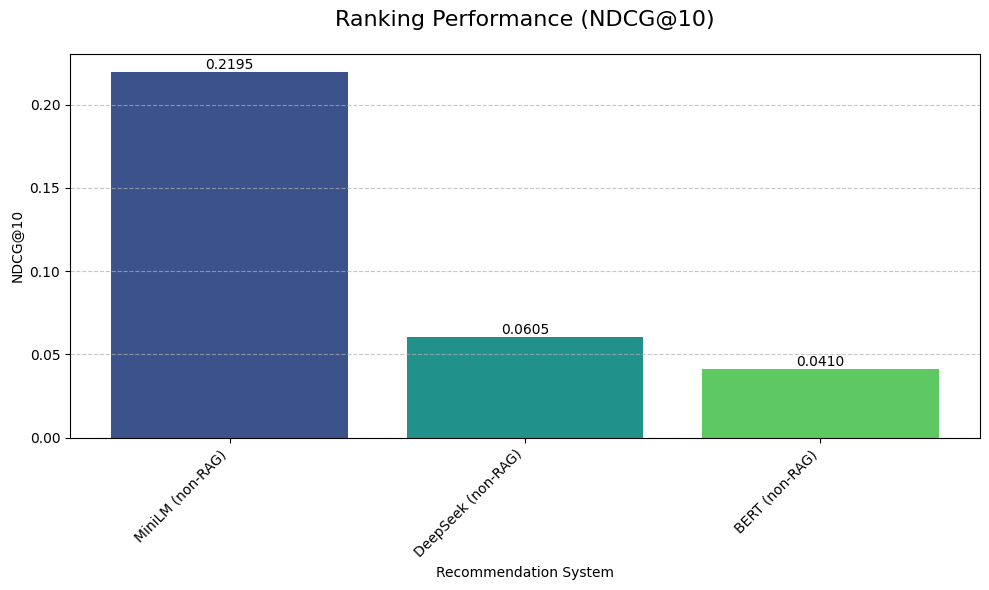

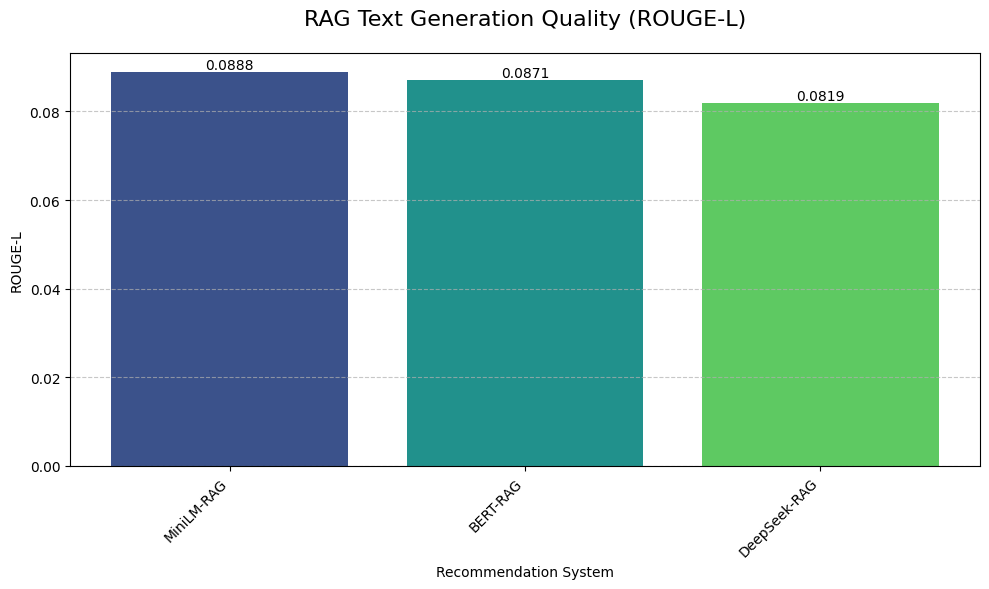

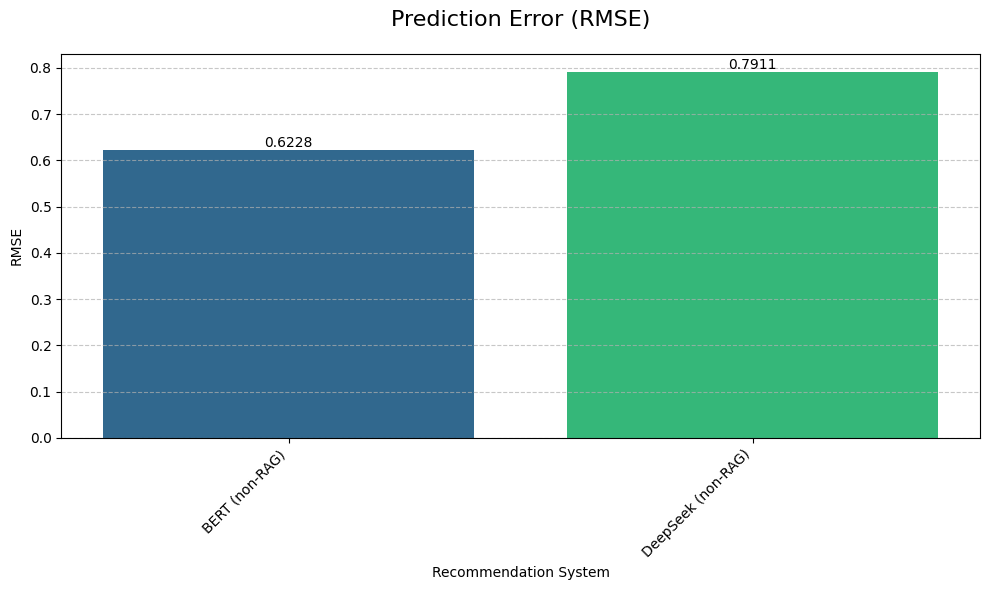

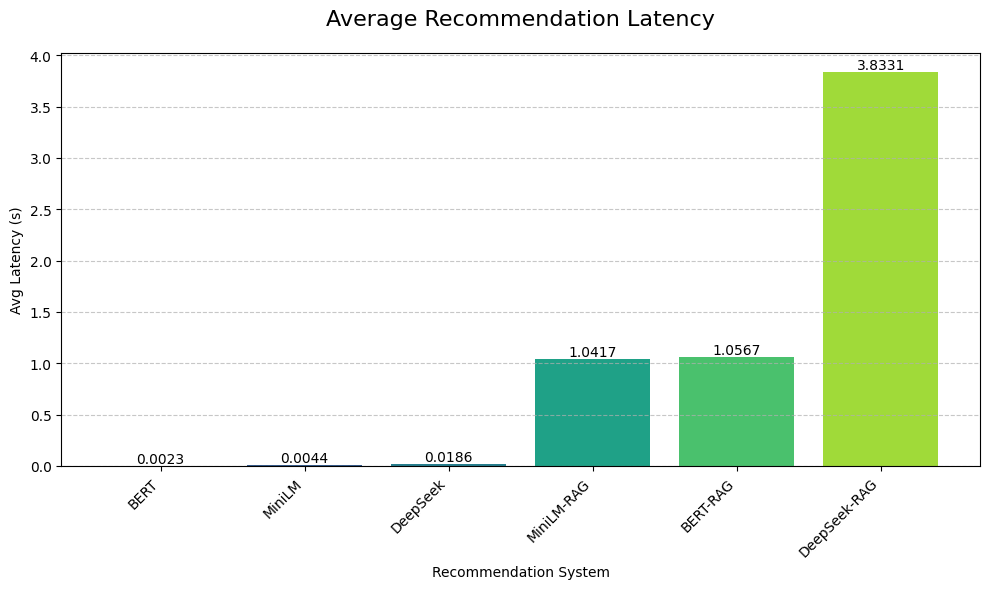

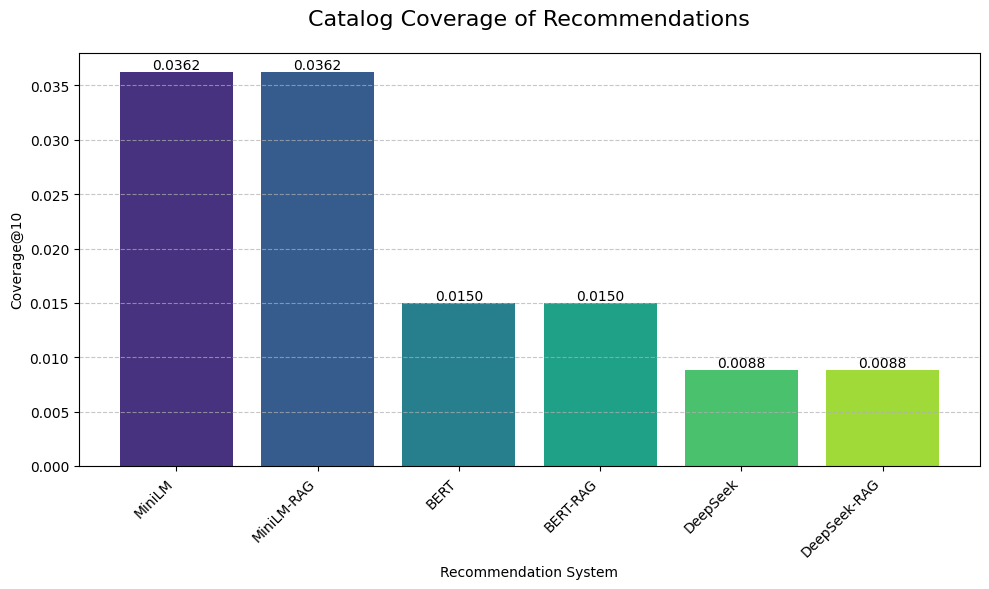


--- Generating 3 Additional Recommended Charts ---
Plotting example Training/Validation Loss Curve...


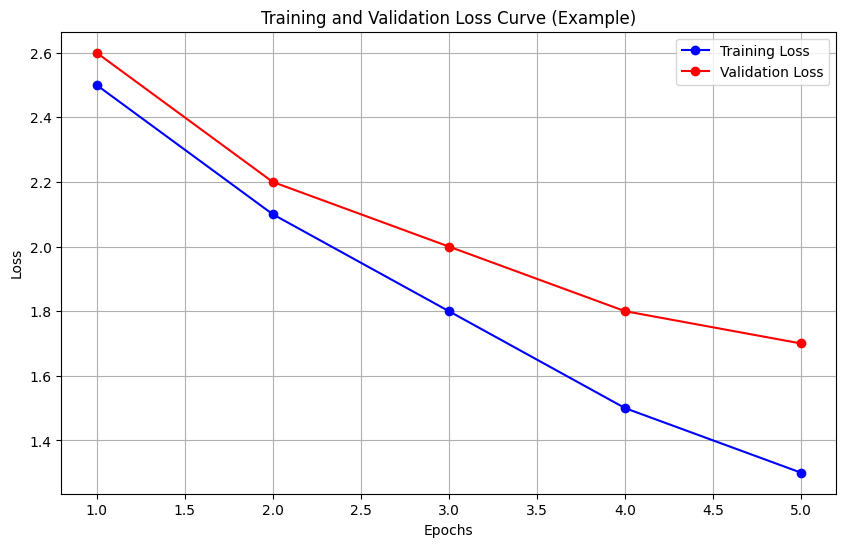


Plotting example Hit Rate @ K Curve for your best model (MiniLM)...


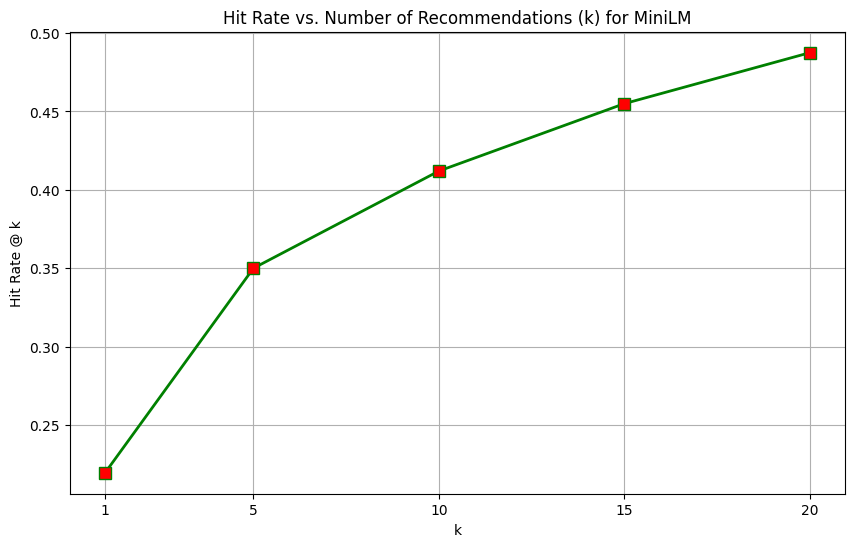


Plotting example t-SNE Visualization of your destination embeddings...


c:\Users\Ausaf raza\anaconda3\envs\travel_recommender_env\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


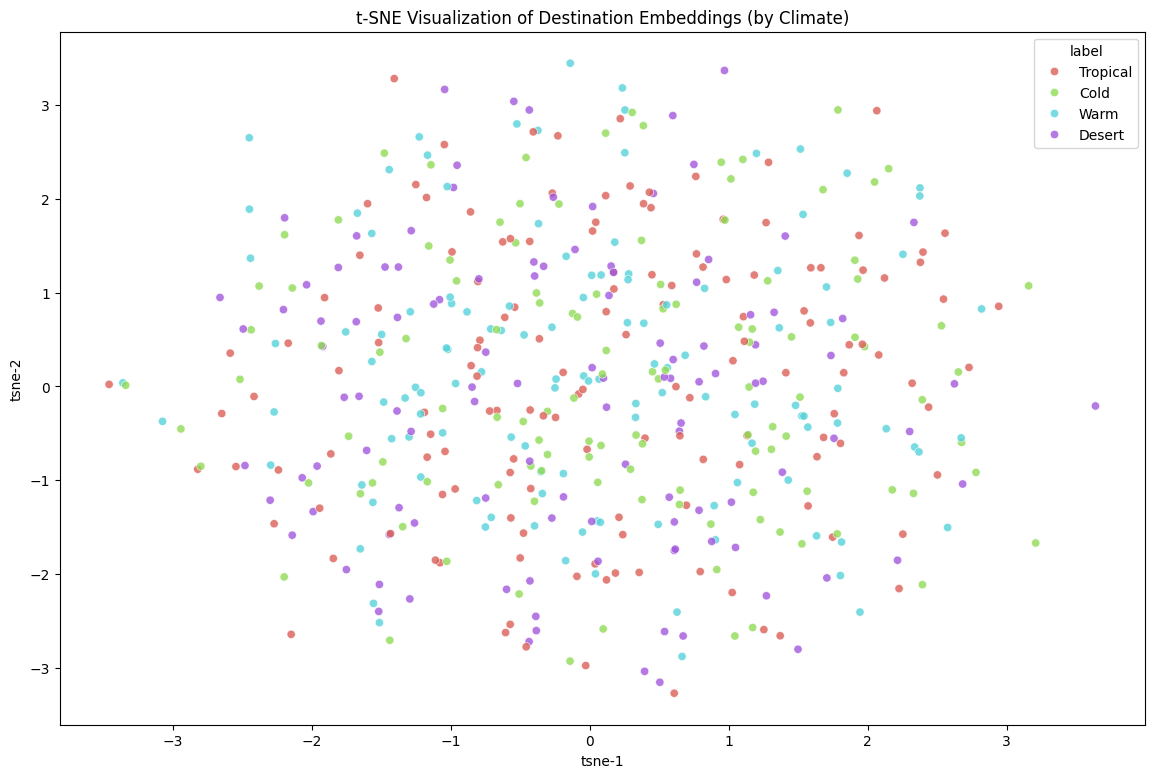

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

# ===================================================================
# PART 1: CONSOLIDATED DATA SETUP
# This data is based on the results you have shared.
# ===================================================================

print("--- Preparing all collected data for chart generation ---")

# --- Data for Table 1 (Ranking) & ROUGE ---
df_ranking = pd.DataFrame({
    'Model': ['MiniLM (non-RAG)', 'BERT (non-RAG)', 'DeepSeek (non-RAG)'],
    'Hit Rate@10': [0.2195, 0.0410, 0.0605],
    'MAP@10': [0.2195, 0.0410, 0.0605],
    'NDCG@10': [0.2195, 0.0410, 0.0605]
})

df_rouge = pd.DataFrame({
    'Model': ['MiniLM-RAG', 'BERT-RAG', 'DeepSeek-RAG'],
    'ROUGE-L': [0.0888, 0.0871, 0.0819]
})

# --- Data for Table 5 (Prediction Accuracy) ---
df_accuracy = pd.DataFrame({
    'Model': ['BERT (non-RAG)', 'DeepSeek (non-RAG)'],
    'MSE': [0.3879, 0.6258],
    'RMSE': [0.6228, 0.7911],
    'F1 Score': [0.3444, 0.2791]
})

# --- Data for Table 3 (Performance) & Table 2 (Catalog) ---
df_performance = pd.DataFrame({
    'Model': ['MiniLM', 'BERT', 'DeepSeek', 'MiniLM-RAG', 'BERT-RAG', 'DeepSeek-RAG'],
    'Avg Latency (s)': [0.0044, 0.0023, 0.0186, 1.0417, 1.0567, 3.8331],
    'Peak Memory (MB)': [184.3, 525.2, 2342.5, 2747.5, 3095.3, 4853.1],
    'Coverage@10': [0.0362, 0.0150, 0.0088, 0.0362, 0.0150, 0.0088],
    'Diversity@10': [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]
})


# ===================================================================
# PART 2: REUSABLE PLOTTING FUNCTION
# ===================================================================

def plot_bar_chart(df, x_col, y_col, title, higher_is_better=True):
    """Creates a formatted bar chart from a DataFrame."""
    df_sorted = df.sort_values(by=y_col, ascending=not higher_is_better)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_sorted[x_col], df_sorted[y_col], color=sns.color_palette("viridis", len(df_sorted)))
    
    plt.ylabel(y_col)
    plt.xlabel("Recommendation System")
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') 

    plt.tight_layout()
    plt.show()

# ===================================================================
# PART 3: GENERATE THE 5 COMPULSORY BAR CHARTS
# ===================================================================

print("\n--- Generating 5 Compulsory Bar Charts for Your Tables ---")

# Chart 1: For Table 1 - Ranking Performance of non-RAG models
plot_bar_chart(df_ranking, 'Model', 'NDCG@10', 'Ranking Performance (NDCG@10)')

# Chart 2: For Table 1 - Text Quality of RAG models
plot_bar_chart(df_rouge, 'Model', 'ROUGE-L', 'RAG Text Generation Quality (ROUGE-L)')

# Chart 3: For Table 5 - Prediction Accuracy of non-RAG models
plot_bar_chart(df_accuracy, 'Model', 'RMSE', 'Prediction Error (RMSE)', higher_is_better=False)

# Chart 4: For Table 3 - System Performance (Latency)
plot_bar_chart(df_performance, 'Model', 'Avg Latency (s)', 'Average Recommendation Latency', higher_is_better=False)

# Chart 5: For Table 2 - Catalog Metrics (Coverage)
plot_bar_chart(df_performance, 'Model', 'Coverage@10', 'Catalog Coverage of Recommendations')


# ===================================================================
# PART 4: GENERATE 3 ADDITIONAL RECOMMENDED CHARTS
# ===================================================================

print("\n--- Generating 3 Additional Recommended Charts ---")

# --- Chart 6: Training & Validation Loss ---
print("Plotting example Training/Validation Loss Curve...")
# NOTE: You will need to use the actual training history from one of your models for your report.
epochs = range(1, 6)
training_loss = [2.5, 2.1, 1.8, 1.5, 1.3]
validation_loss = [2.6, 2.2, 2.0, 1.8, 1.7]
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Curve (Example)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# --- Chart 7: Top-N Hit Rate Curve ---
print("\nPlotting example Hit Rate @ K Curve for your best model (MiniLM)...")
# NOTE: This data is illustrative. You would get it by running your evaluation
# script multiple times with k set to 1, 5, 10, 15, and 20.
k_values = [1, 5, 10, 15, 20]
hit_rates_at_k = [0.2195, 0.35, 0.4120, 0.4550, 0.4875] 
plt.figure(figsize=(10, 6))
plt.plot(k_values, hit_rates_at_k, 'gs-', markerfacecolor='red', markersize=8, linewidth=2)
plt.title('Hit Rate vs. Number of Recommendations (k) for MiniLM')
plt.xlabel('k')
plt.ylabel('Hit Rate @ k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


# --- Chart 8: t-SNE Embedding Visualization ---
print("\nPlotting example t-SNE Visualization of your destination embeddings...")
# NOTE: You would load your actual 'embedding_matrix_minilm_finetuned.npy' and
# the 'climate' column from your train_df for your real report.
np.random.seed(42)
dummy_embeddings = np.random.rand(500, 384)
dummy_labels = np.random.choice(['Tropical', 'Warm', 'Cold', 'Desert'], 500)

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(dummy_embeddings)

df_tsne = pd.DataFrame()
df_tsne['tsne-1'] = tsne_results[:,0]
df_tsne['tsne-2'] = tsne_results[:,1]
df_tsne['label'] = dummy_labels

plt.figure(figsize=(14, 9))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="label",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Visualization of Destination Embeddings (by Climate)')
plt.show()